<a href="https://colab.research.google.com/github/Timliuw/DP-Tim/blob/main/CI_Tim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
import math
import numpy as np
import copy
import getopt
import psycopg2
import sys
import time
import pandas as pd
import uuid

In [2]:
# Google Spreadsheet
import gspread
from google.auth.transport.requests import Request
from google.oauth2.service_account import Credentials
from oauth2client.service_account import ServiceAccountCredentials
from google.colab import files
# uploaded = files.upload()
import os
os.listdir()

scope = [
    "https://spreadsheets.google.com/feeds",  # Google Sheets API
    "https://www.googleapis.com/auth/drive"   # Google Drive API
]

# Trigger the file upload dialog
try:
    creds = ServiceAccountCredentials.from_json_keyfile_name("sublime-mission-447319-c2-0df1612796a8.json", scope)
except:
   uploaded = files.upload()

creds = ServiceAccountCredentials.from_json_keyfile_name("sublime-mission-447319-c2-0df1612796a8.json", scope)
client = gspread.authorize(creds)

spreadsheet = client.open_by_key("1yVVt5ACdBbjsZ_7IiRkvPGIHmpKe8mFXcvyL0PVP2cE")

worksheet1 = spreadsheet.get_worksheet(0)
worksheet = worksheet1
worksheet2 = spreadsheet.get_worksheet(1)

def get_color(curr_value, prev_value):
    if curr_value < 0.6 * prev_value:
        return {"red": 0.6, "green": 1.0, "blue": 0.6}  # very green
    elif curr_value < prev_value:
        return {"red": 0.8, "green": 1.0, "blue": 0.8}  # green
    elif curr_value > 1.4 * prev_value:
        return {"red": 1.0, "green": 0.6, "blue": 0.6}  # very red
    elif curr_value > prev_value:
        return {"red": 1.0, "green": 0.8, "blue": 0.8}  # red
    return None

def write_to_sheet(worksheet, row_data, output_mode=0, compare=False):
    # Append the new row to the sheet
    try:
        worksheet.append_row(row_data)
    except Exception as e:
        print(f"Error occurred: {e}")
        print(f"Row data: {row_data}")
    # Format colour according to the comparing results
    if compare:
        pre_row_index = -2
        if (output_mode == 2): pre_row_index = -18
        sheet_data = worksheet.get_all_values()
        last_row_index = len(sheet_data)
        if last_row_index > 1:
            last_row = sheet_data[-1]
            prev_row = sheet_data[pre_row_index]
            for col_index, (curr_value, prev_value) in enumerate(zip(last_row, prev_row), start=1):
                try:
                    curr_value = float(curr_value)
                    prev_value = float(prev_value)
                    if (worksheet.row_values(1)[col_index-1] == "est median"):
                      prev_value = abs(true_med - prev_value)
                      curr_value = abs(true_med - curr_value)
                    color = get_color(curr_value, prev_value)
                    if color:
                        worksheet.format(f"{chr(64 + col_index)}{last_row_index}", {"backgroundColor": color})
                except:
                    continue

In [3]:
def discretize(D, b):
    n = len(D)
    discreteD = np.zeros(n)
    for i in range(n):
        discreteD[i] = int(D[i]/b)
    return discreteD

def discrete(D):
    n = len(D)
    newD = np.zeros(n)
    previous = -1
    for i in range(n):
        if D[i]!=previous:
            newD[i] = n*D[i]
            #print(newD[i])
            previous = D[i]
        elif D[i]==previous:
            newD[i] = newD[i-1]+1

    return newD

def count(D, a):
    counter = 0
    n = len(D)
    low = 0
    up=n-1
    mid = int((low+up)/2)
    while True:
        if D[mid]>a:
            up=mid
            mid = int((low+up)/2)
        if D[mid]<a:
            low=mid
            mid = int((low+up)/2)
        if D[mid]==a:
            i=0
            while D[mid+i]==a:
                i+=1
            return mid+i

def clip(D, a, b):
    clipped = copy.deepcopy(D)
    clipped[clipped<a] = a
    clipped[clipped>b] = b
    return clipped

def LapNoise():
    a = random.uniform(0,1)
    b = math.log(1/(1-a))
    c = random.uniform(0,1)
    if c>0.5:
        return b
    else:
        return -b

def F(x):
    return 1/2+1/(4*math.pi)*(math.log(abs(2*x**2+2*math.sqrt(2)*x+2)/abs(abs(2*x**2-2*math.sqrt(2)*x+2)))+2*math.atan(math.sqrt(2)*x+1)+2*math.atan(math.sqrt(2)*x-1))
def inver_F(y):
    #find the solution of F(x)=y
    #Find between -1000000 and 1000000 because F(1000000)=1.0 in python
    if y>1/2:
        low =0.0
        high = 1000000.0
        mid = (high+low)/2
        while abs(high-low)>0.0000001:
            if F(mid)>y:
                high=mid
            elif F(mid)==y:
                return mid
            else:
                low = mid
            mid = (high+low)/2

        return high
    if y==1/2:
        return 0

def CauchyNoise():
    a = random.uniform(0.5,1)
    b = inver_F(a)
    c = random.uniform(0,1)
    if c>0.5:
        return b
    else:
        return -b

In [4]:
# Their algorithm
def constructu(eps, a,b, D):
    # global u
    # global l
    # global weight
    #[a,b] denotes range
    n = len(D)

    u = np.zeros(n+2)#utility score
    l = np.zeros(n+2)#corresponding data
    l[0] = a
    for i in range(n+1): #i=rank-1
        if i<=int(n/2):
            u[i] = -int(n/2)-1+i
            l[i+1]= D[i]
        #u[int(n/2+1)] = 0
        #l[int(n/2+2)] = D[int(n/2)]
        if i>int(n/2):
            u[i] = int(n/2)+1-i
            l[i]= D[i-1]

    l[n+1] = b
    u[n+1] = -n-1-u[0]
    weight = []
    # l[i] corresponds to data in D with rank i
    for i in range(int(n/2)+1): # weight[0...n/2]
        weight.append((l[i+1]-l[i])*math.pow(np.e, eps*u[i]/2)) #weight[i]=(l[i+1]-l[i])...
        # if (i == int(n/2)): print(l[i+1],l[i],u[i])
    weight.append(1) # weight[n/2+1] = 1??
    for i in range(int(n/2)+1,n+1): #weight[n/2+2..n+1]
        weight.append((l[i]-l[i-1])*math.pow(np.e, eps*u[i]/2)) #weight[i+1]=(l[i]-l[i-1])...
        # if (i == int(n/2)+1): print(l[i],l[i-1],u[i])
    # worksheet.append_row(weight)
    totalWeight = sum(weight)
    weight = weight/totalWeight
    # df['Their weights'] = weight
    # df["Their u"] = list(u)
    return u, l, weight

def EMMedian_new(l,weight):
    i = np.random.choice(list(range(len(l))), p=weight)
    # only return int
    if i==int(n/2)+1:
        return int(l[i]/n)
    if i<int(n/2)+1:
        return int(np.random.randint(l[i], l[i+1],dtype=np.int64) / n)
    if i>int(n/2)+1:
        return int(np.random.randint(l[i-1], l[i],dtype=np.int64) / n)

def constructu_CI(eps, beta, N, u, l):
    # global u1
    # global weight1
    # global u2
    # global weight2
    # global factor

    factor = int(8/eps*np.log(4*n*N/beta))
    print("factor is "+str(factor))
    #u1: left util
    #u2: right util
    u1 = np.zeros(n+2)
    u2 = np.zeros(n+2)
    for i in range(n+2):
        if i<=int(n/2)+1:
            u1[i] = -abs(u[i]+factor)
            u2[i] = u[i]-factor
        else:
            u1[i] = u[i]-factor
            u2[i] = -abs(u[i]+factor)

    idx = int(n/2)+1-factor
    weight1 = []
    for i in range(idx):
        weight1.append((l[i+1]-l[i])*math.pow(np.e, eps*u1[i]/4))
    weight1.append(1)
    for i in range(idx,n+1):
        weight1.append((l[i]-l[i-1])*math.pow(np.e, eps*u1[i]/4))
    totalWeight1 = sum(weight1)
    weight1 = weight1/totalWeight1

    idx = int(n/2)+1+factor
    idx = min(int(n/2)+1+factor,n+1)
    weight2 = []
    for i in range(idx):
        weight2.append((l[i+1]-l[i])*math.pow(np.e, eps*u2[i]/4))
    weight2.append(1)
    for i in range(idx,n+1):
        weight2.append((l[i]-l[i-1])*math.pow(np.e, eps*u2[i]/4))

    totalWeight2 = sum(weight2)
    weight2 = weight2/totalWeight2
    return u1,weight1,u2,weight2,factor

def EMMedianCI(l,weight,weight1, weight2,factor):
    i1 = np.random.choice(list(range(len(l))), p=weight1)
    if i1==int(n/2)+1-factor:
        x1= int(l[i1]/n)
    if i1<int(n/2)+1-factor:
        x1= int(np.random.randint(l[i1], l[i1+1],dtype=np.int64)/n)
    if i1>int(n/2)+1-factor:
        x1= int(np.random.randint(l[i1-1], l[i1],dtype=np.int64)/n)

    i2 = np.random.choice(list(range(len(l))), p=weight2)
    if i2==int(n/2)+1+factor:
        x2= int(l[i2]/n)
    if i2<int(n/2)+1+factor:
        x2= int(np.random.randint(l[i2], l[i2+1],dtype=np.int64)/n)
    if i2>int(n/2)+1+factor:
        x2= int(np.random.randint(l[i2-1], l[i2],dtype=np.int64)/n)

    est = EMMedian_new(l,weight)
    indicator=0
    if D[int(n/2)]<=x2 and D[int(n/2)]>=x1:
        indicator=1

    return x1,x2 ,indicator,est

In [5]:
eps = []
beta = []
D = []
newD = []
domain_size = 4000
num_repeat = 100
b_list_step = 1


In [6]:
# Our algorithm
#1) Learn noisy median o of distribution using Exponential Mechanism
def EM_median(eps,beta,D,domain_size):
    #print("Results for EM, beta = "+str(beta) + ", epsilon = " + str(eps))
    interval_prob = []

    # D = np.array([lowest]) + D
    vals, counts = np.unique(D,return_counts=True)
    # for i in range(len(counts)):
    #   if (counts[i] != 1): print("!=1:",vals[i],counts[i])
    rank = 0
    lowest = D[0]
    vals = [lowest-1]+vals.tolist() # val[i-1] maps to D[i]
    counts = [0] + counts.tolist()
    cdf = 0.0
    rank_dict = {}
    weights = []
    u = []
    n = len(D)

    # (vals[i-1],vals[i]] uses vals[i]'s rank to compute its weight
    for i in range(1,len(vals)):
        # rank += counts[i-1] # bug?
        rank_dict[vals[i-1]] = rank # rank of vals[i-1] = rank
        rank += counts[i] # fixed bug
        utility = -1.0* np.abs(rank - (n/2)) # use vals[i]'s rank to compute utlity of vals[i-1]
        u.append(utility) # u[i-1] = utility, corresponding to vals[i-1]. No u for max(D)
        p = (vals[i] - vals[i-1])* math.pow(np.e, eps*utility/2) # accuracy bug?
        cdf += p
        weights.append(p) # weight[i-1] = p, corresponding to interval (vals[i-1],vals[i]]
        # print(vals[i-1],p)
        if use_discretized == 0:
          for j in range(counts[i-1]-1):
            weights.append(".")
            u.append(".")
        interval_prob.append(cdf) # interval[i-1] = cdf,corresponding to interval (val[i-1],val[i]]
    if use_discretized == 0:
      for j in range(counts[len(vals)-1]):
          weights.append(".")
          u.append(".")

    # print("our weight len",len(weight))
    rand_val = cdf * np.random.uniform(0,1)
    rank_o = 0
    # print("total weights:",sum(weights))
    if (use_discretized == 0):
      weight_name = 'our weights'
      u_name = 'our u'
    else:
      weight_name = 'our weights(discre)'
      u_name = 'our u(discre)'
    # df[weight_name] = weights + ["."]
    # df[u_name] = u + ["."]
    # print("cdf:",cdf,"rand_val",rand_val)
    for i in range(0,len(vals)-1):
        # print("--------(",vals[i],vals[i+1],"]---------")
        # for j in range(1, 20):
        #   print(int(np.random.randint(vals[i]+1, vals[i+1]+1,dtype=np.int64)))
        if rand_val <= interval_prob[i]:
          sens = 1
          ci = (2 * sens / eps) * (np.log(domain_size / beta))
          # o = np.random.uniform(vals[i-1],vals[i])
          # print(vals[i],vals[i+1])
          o = int(np.random.randint(vals[i]+1, vals[i+1]+1,dtype=np.int64)) # (vals[i],vals[i+1]]
          # print("i:", i, "vals[i]:", vals[i],"vals[i+1]:",vals[i+1])
          # rank_o = rank_dict[vals[i]] # bug
          rank_o = rank_dict[vals[i+1]] # fixed?
          # print("rank_o:",rank_o,"vals[i] and vals[i+1]",vals[i],vals[i+1])
          break
    return o,rank_o,rank_dict

#2)
def find_rank(rank_dict,val):
    ranks = list(rank_dict.values())
    keys = list(rank_dict.keys())
    output = 0
    # val in (key[i],key[i+1]] has the same rank as key[i+1]
    for i in range(len(ranks)-1):
        if val <= keys[i+1]:
            # output = ranks[i] # bug?
            output = ranks[i+1]
            break
    #print(rank_dict[output])
    return output#int(output)


def SVT_median(o,rank_o,rank_dict,eps,D,domain_size,T,b_list):
    # print("T: ", T)
    noisy_T = T + np.random.laplace(2/eps)
    sensitivity = 1
    bounds = domain_size #???
    #print(min(o+bounds,domain_size-1))
    for b in b_list: #range(0,b_max,step):
        perturbed_value = min(abs(find_rank(rank_dict, o+b)-rank_o),abs(find_rank(rank_dict, o-b)-rank_o)) + np.random.laplace(2*sensitivity/eps)
        # print("o:",o,"rank_o",rank_o)
        # print("find_rank(rank_dict, o)",find_rank(rank_dict, o))
        # print(min(abs(find_rank(rank_dict, o+b)-rank_o),abs(find_rank(rank_dict, o-b)-rank_o)))
        if perturbed_value > noisy_T:
            bounds = b
            # print("b:",b,"perturbed_value:",perturbed_value,"noisy_T:",noisy_T)
            break
    #print(max(o-bounds,0))

    # print(perturbed_value)
    # result = max(o-bounds,0),min(o+bounds,domain_size-1) # bug? consider o=max(D)
    # result = max(o-bounds,0),min(o+bounds,D[-1]-1) # fixed?
    # result = max(o-bounds,0),min(o+bounds,D[-1])
    result = max(o-bounds,D[0]),min(o+bounds,D[-1]) #

    # print(b,result)
    return result



def Their_EMMedian_modified(l,weight,D):
    vals, counts = np.unique(D,return_counts=True)
    rank_dict = {}
    rank = 0
    vals = [0.0] + vals.tolist()
    for i in range(1,len(vals)):
        rank += counts[i-1]
        rank_dict[vals[i]] = rank
    i = np.random.choice(list(range(len(l))), p=weight)
    # only return int
    val = 0
    if i==int(n/2)+1:
      val = int(l[i])
    if i<int(n/2)+1:
      val = int(np.random.randint(l[i], l[i+1],dtype=np.int64))
    if i>int(n/2)+1:
      val = int(np.random.randint(l[i-1], l[i],dtype=np.int64))
      i=i-1
    return val,i,rank_dict #rank_dict is from global variable

##### main function ######

def our_CI(D,domain_size,b_list,med_method=0,l=[],weight=[]):
    C = (2/eps_1) *(np.log(domain_size/beta_1)) # γ
    m = len(b_list)
    alpha = (8*np.log(m)+np.log(2/beta_2)) / eps_2
    #print("C", C)
    #print("alpha", alpha)
    T = C + alpha
    if (med_method==1):
      o,rank_o,rank_dict = Their_EMMedian_modified(l,weight,D) #their EM
    else:
      o,rank_o,rank_dict = EM_median(eps_1,beta_1,D,domain_size) #our EM
    lower,upper = SVT_median(o,rank_o,rank_dict,eps_2,D,domain_size,T,b_list)
    #print("median:",o)
    #print("The bounds are:")
    #print('[{},{}]'.format(lower,upper))
    indi = -1 #if CI contains true med
    if (use_discretized == 1):
      if lower < D[0]: lower = D[0]
      if upper > D[-1]: upper = D[-1]
      lower,upper = lower/n,upper/n
      o /= n

    # if true_med < upper and true_med > lower:
    if true_med <= upper and true_med >= lower: #new
        indi = 1
    else:
        indi = 0
    return lower,upper,indi,o


In [7]:
def test_ours(b_list_step=b_list_step,eps=eps, beta=beta, num_repeat=num_repeat,D=D,compare = False,output=[],med_method = 0,name=""):
  # med_method: 0 use our EM
  #      : 1 use their EM (use_discretized must = 1)
  domain_size = int(max(D)-min(D))
  if (use_discretized == 1):
    b_list = range(0, b_list_step*int(domain_size/b_list_step),n*b_list_step)
    if (med_method == 1):
      rad = 10000000
      left = -rad
      u,l,weight=constructu(eps_1,left*n,rad*n, D)
  else:
    # b_list = range(0, domain_size, b_list_step)
    b_list = range(0, b_list_step*int(domain_size/b_list_step),b_list_step)
  len_eps = []
  err_eps = []
  est_median = []
  times = []
  ranks = []
  lengths = []
  errors = []
  rank_errors_1 = [] # based on n/2
  rank_errors_2 = [] # based on find_rank(rank_dict,true_med)
  rank_CI_lengths = []
  # est_list = []
  med_rank = int(find_rank(rank_dict, true_med))
  print("rank_dict:",rank_dict)
  print("med_rank:",med_rank)
  for i in range(len(beta)):
      print("Results for EM based median, beta = "+str(beta[i]))
      correct_count = 0

      for j in range(num_repeat):
          start = time.time()
          if med_method == 0:
            xl,xr,indi,est = our_CI(D,domain_size,b_list)#EMMedianCI()
          else:
            xl,xr,indi,est = our_CI(D,domain_size,b_list,med_method,l,weight)
          end = time.time()
          times.append(end-start)
          correct_count+=indi
          lengths.append((xr-xl)/(2))
          # print(xr,xl)
          # interesting and subtle difference!
          # mid_value = (xr+xl)/2
          errors.append(abs(est-true_med))
          est_median.append(est)
          rank = int(find_rank(rank_dict, est))
          ranks.append(rank)
          rank_errors_1.append(int(abs(n/2 - rank)))
          rank_errors_2.append(int(abs(med_rank - rank)))
      original_errors = errors
      errors = np.array(errors, dtype=object)
      correct_rate = correct_count/num_repeat
      avgLength = sum(lengths)/num_repeat
      errors.sort()
      errorQuantile = errors[int(num_repeat*(1-beta[i]))]
      avg_error = np.average(errors)
      avgTime = sum(times)/len(times)

      # rank CI length
      rank_lower = int(find_rank(rank_dict,xl))
      rank_upper = int(find_rank(rank_dict,xr))
      rank_CI_length = (rank_upper-rank_lower)/2
      rank_CI_lengths.append(rank_CI_length)


      # output medians and error

      #download errors
      # df = pd.DataFrame(errors)
      # file_name = f"data_error.csv"
      # df.to_csv(file_name, index=False, header=False)
      # files.download(file_name)

      # median_error
      if np.all(errors == errors[0]):
          stddev_based_avg_err = errors[0]
          IQR_based_avg_err = errors[0]
      else:
          std_dev = np.std(errors)
          stddev_based_avg_err = np.average(errors[np.abs(errors - avg_error) < 3 * std_dev])
          q1 = np.percentile(errors, 25)
          q3 = np.percentile(errors, 75)
          iqr = q3 - q1
          lower_bound = q1 - 1.5 * iqr
          upper_bound = q3 + 1.5 * iqr
          IQR_based_avg_err = np.average(errors[(errors >= lower_bound) & (errors <= upper_bound)])
      # rank_error
      avg_rank_error_1 = np.average(rank_errors_1)
      avg_rank_error_2 = np.average(rank_errors_2)

      # avg rank CI length
      avg_rank_CI_length = np.average(rank_CI_lengths)

      if name=="":
        name = "our_CI"
        if (use_discretized == 1):
          name = "our_CI(discretized)"
          domain_size = int(domain_size/n)
          if (med_method == 1): name = "our_CI(their EM)"
      if (errorQuantile == 0): relative_CI_width = -1
      else: relative_CI_width = avgLength / errorQuantile
      print("CI:",xl,xr)
      print("estimated median value: "+ str(np.average(est_median)))
      print("correct rate = ", correct_rate)
      print("Average CI length = "+str(avgLength))
      print("error quantile is "+ str(errorQuantile))
      print("CI length/ error quantile = "+str(relative_CI_width))
      print("Average Time to find CI = " + str(avgTime))


      row_data = [
          name,
          data_uuid,
          n,
          domain_size,
          sens,
          beta[i],
          eps[i],
          num_repeat,
          true_med,
          np.average(est_median),
          correct_rate,
          avgLength,
          errorQuantile,
          avg_error,
          stddev_based_avg_err,
          IQR_based_avg_err,
          avg_rank_error_1,
          avg_rank_error_2,
          relative_CI_width,
          avg_rank_CI_length,
          avgTime,
          b_list_step,
          beta_1,
          beta_2,
          eps_1,
          eps_2
      ]
      if (output_mode == 0 or output_mode == 2):
        write_to_sheet(worksheet1, row_data, output_mode=output_mode, compare=compare)

      # New! Check all medians and errors
      if (output_mode == 1 or output_mode == 2):
        sorted_med = sorted(est_median)
        est_median.insert(0, "Our est_median")
        sorted_med.insert(0, "Sorted Our est_median")

        sorted_errors = sorted(original_errors)
        original_errors.insert(0, "Our errors")
        sorted_errors.insert(0, "Sorted Our errors")

        sorted_ranks = sorted(ranks)
        ranks.insert(0, "Our ranks")
        sorted_ranks.insert(0, "Sorted Our ranks")

        sorted_lengths = sorted(lengths)
        lengths.insert(0,"Our CI lengths")
        sorted_lengths.insert (0, "Sorted Our CI lengths")

        sorted_re_1 = sorted(rank_errors_1)
        sorted_re_2 = sorted(rank_errors_2)
        rank_errors_1.insert(0, "Our rank_errors(n/2)")
        rank_errors_2.insert(0, "Our rank_errors(find)")
        sorted_re_1.insert(0, "Sorted Our rank_errors(n/2)")
        sorted_re_2.insert(0, "Sorted Our rank_errors(find)")


        data_uid_row = ["data:", data_uuid, "method:", "Our_CI"]
        true_med_row = ["true median"]+[true_med]*num_repeat
        n_over_2_row = ["true n/2"] + [n/2]*num_repeat
        med_rank_row = ["true med_rank(find)"] + [med_rank]*num_repeat

        worksheet.append_row(data_uid_row)
        worksheet.append_row(est_median)
        worksheet.append_row(true_med_row)
        worksheet.append_row(original_errors)
        # write_to_sheet(worksheet1, errors, output_mode=output_mode, compare=compare)
        worksheet.append_row(ranks)
        worksheet.append_row(n_over_2_row)
        worksheet.append_row(rank_errors_1)
        # write_to_sheet(worksheet1, rank_errors_1, output_mode=output_mode, compare=compare)
        worksheet.append_row(med_rank_row)
        worksheet.append_row(rank_errors_2)
        worksheet.append_row(lengths)

        # write_to_sheet(worksheet1, rank_errors_2, output_mode=output_mode, compare=compare)
        worksheet.append_row(sorted_med)
        worksheet.append_row(sorted_ranks)
        worksheet.append_row(sorted_errors)
        worksheet.append_row(sorted_re_1)
        worksheet.append_row(sorted_re_2)
        worksheet.append_row(sorted_lengths)

      len_eps.append(avgLength)
      err_eps.append(errorQuantile)
      print(len_eps)
      print(err_eps)
      if (output_mode == 3):
        output = row_data
        return output

In [8]:
def test_theirs(eps=eps, beta=beta, num_repeat=num_repeat, D=newD,median_method = 0,compare = False,output=[]):
  #median_method = 0:median from CI algorithm
  #        = 1:median from EMMedianCI
  n = len(newD)
  domain_size = int((max(D)-min(D))/n)
  len_eps = []
  err_eps = []
  est_median = []
  times = []
  ranks = []
  EM_median_errors = []
  med_rank = int(find_rank(rank_dict, true_med))
  est_list = []
  rank_errors_1 = [] # based on n/2
  rank_errors_2 = [] # based on find_rank(rank_dict,true_med)
  rank_CI_lengths = []
  for i in range(len(beta)):
      print("Results for EM based median, beta = "+str(beta[i]))
      errors = []
      lengths = []
      correct_count = 0
      rad = 10000000
      left=-rad
      u,l,weight = constructu(eps[i], left*n,rad*n, newD)
      u1,weight1,u2,weight2,factor = constructu_CI(eps[i],beta[i], rad,u,l)
      for j in range(num_repeat):
          start = time.time()
          xl,xr,indi,est = EMMedianCI(l,weight,weight1,weight2,factor)
          end = time.time()
          times.append(end-start)
          correct_count+=indi
          lengths.append((xr-xl)/(2))
          if (median_method == 0):
            their_median = (xr+xl)/2
          else:
            their_median = est
          est_median.append(their_median)
          errors.append(abs(their_median-true_med))
          EM_median_errors.append(abs(est-true_med)) # their def of errors
          rank = int(find_rank(rank_dict, their_median))
          ranks.append(rank)
          rank_errors_1.append(int(abs(n/2 - rank)))
          rank_errors_2.append(int(abs(med_rank - rank)))

          # rank CI length
          rank_lower = int(find_rank(rank_dict,xl))
          rank_upper = int(find_rank(rank_dict,xr))
          rank_CI_length = (rank_upper-rank_lower)/2
          rank_CI_lengths.append(rank_CI_length)

      original_errors = errors
      errors = np.array(errors, dtype=object)
      correct_rate = correct_count/num_repeat
      avgLength = sum(lengths)/num_repeat
      errors.sort()
      errorQuantile = errors[int(num_repeat*(1-beta[i]))]

      avgTime = sum(times)/len(times)


      errors = np.array(errors)
      avg_error = np.average(errors)
      if (errorQuantile == 0): relative_CI_width = -1
      else: relative_CI_width = avgLength / errorQuantile
      if np.all(errors == errors[0]):
          stddev_based_avg_err = errors[0]
          IQR_based_avg_err = errors[0]
      else:
          std_dev = np.std(errors)
          stddev_based_avg_err = np.average(errors[np.abs(errors - avg_error) < 3 * std_dev])

          q1 = np.percentile(errors, 25)
          q3 = np.percentile(errors, 75)
          iqr = q3 - q1
          lower_bound = q1 - 1.5 * iqr
          upper_bound = q3 + 1.5 * iqr
          IQR_based_avg_err = np.average(errors[(errors >= lower_bound) & (errors <= upper_bound)])

      #rank_error avg
      avg_rank_error_1 = np.average(rank_errors_1)
      avg_rank_error_2 = np.average(rank_errors_2)
      print("Filtered Errors for IQR_based_avg_err:", IQR_based_avg_err)
      # avg rank CI length
      avg_rank_CI_length = np.average(rank_CI_lengths)

      print("estimated median value: "+ str(np.average(est_median)))
      print("correct rate = " +str(correct_count/num_repeat))
      print("Average CI length = "+str(avgLength))
      print("error quantile is "+ str(errorQuantile))
      print("CI length/ error quantile = "+str(avgLength/errorQuantile))
      print("Average Time to find CI = " + str(sum(times)/len(times)))
      # print("Errors:", errors)
      # print("Standard Deviation:", std_dev)
      # print("Filtered Errors for stddev_based_avg_err:", errors[np.abs(errors - avg_error) < 3 * std_dev])

      # print("Q1:", q1, "Q3:", q3)
      # print("IQR:", iqr)
      # print("Lower Bound:", lower_bound, "Upper Bound:", upper_bound)
      if (median_method == 0):
        name = "EM_CI"
      else:
        name = "EM"
      row_data = [
          name,
          data_uuid,
          n,
          domain_size, #3
          sens, #4
          beta[i],#5
          eps[i], #6
          num_repeat, #7
          true_med, #8
          np.average(est_median), #9
          correct_rate, #10
          avgLength, #11
          errorQuantile, #12
          avg_error,#13
          stddev_based_avg_err, #14
          IQR_based_avg_err, #15
          avg_rank_error_1, #16
          avg_rank_error_2, #17
          relative_CI_width, #18
          avg_rank_CI_length, #19
          avgTime
      ]
      if (output_mode == 0 or output_mode == 2):
        write_to_sheet(worksheet1, row_data, compare = compare)

      if (output_mode == 1 or output_mode == 2):
        sorted_med = sorted(est_median)
        est_median.insert(0, "EM est_median")
        sorted_med.insert(0, "Sorted EM est_median")

        sorted_errors = sorted(original_errors)
        original_errors.insert(0, "EM errors")
        sorted_errors.insert(0, "Sorted EM errors")

        sorted_ranks = sorted(ranks)
        ranks.insert(0, "EM ranks")
        sorted_ranks.insert(0, "Sorted EM ranks")

        sorted_re_1 = sorted(rank_errors_1)
        sorted_re_2 = sorted(rank_errors_2)
        rank_errors_1.insert(0, "EM rank_errors(n/2)")
        rank_errors_2.insert(0, "EM rank_errors(find)")
        sorted_re_1.insert(0, "Sorted EM rank_errors(n/2)")
        sorted_re_2.insert(0, "Sorted EM rank_errors(find)")

        sorted_lengths = sorted(lengths)
        lengths.insert(0,"EM CI lengths")
        sorted_lengths.insert (0, "Sorted EM CI lengths")

        data_uid_row = ["data:", data_uuid, "method:", "EM_CI"]
        true_med_row = ["true median"]+[true_med]*num_repeat
        n_over_2_row = ["true n/2"] + [n/2]*num_repeat
        med_rank_row = ["true med_rank(find)"] + [med_rank]*num_repeat

        print(est_list)
        worksheet.append_row(data_uid_row)
        worksheet.append_row(est_median)
        worksheet.append_row(true_med_row)

        worksheet.append_row(original_errors)
        # write_to_sheet(worksheet1, original_errors, output_mode=output_mode, compare=compare)
        worksheet.append_row(ranks)
        worksheet.append_row(n_over_2_row)
        worksheet.append_row(rank_errors_1)
        # write_to_sheet(worksheet1, rank_errors_1, output_mode=output_mode, compare=compare)
        worksheet.append_row(med_rank_row)
        worksheet.append_row(rank_errors_2)
        worksheet.append_row(lengths)
        # write_to_sheet(worksheet1, rank_errors_2, output_mode=output_mode, compare=compare)
        worksheet.append_row(sorted_med)
        worksheet.append_row(sorted_ranks)
        worksheet.append_row(sorted_errors)
        worksheet.append_row(sorted_re_1)
        worksheet.append_row(sorted_re_2)
        worksheet.append_row(sorted_lengths)



      len_eps.append(avgLength)
      err_eps.append(errorQuantile)
      print(len_eps)
      print(err_eps)
      if (output_mode == 3):
        output = row_data
      return output

In [9]:
def readInput(mode,read_data_uuid="64b7c8bf89f14113bd12f5f15e276546"):
    import numpy as np
    file_paths = {
        0: ("./bank_marketing.csv", 5),
        1: ("./adult.csv", 2),
        2: ("./sample_data/california_housing_test.csv", 3),
        3: ("./sample_data/california_housing_test.csv", 8),
        5: ("./ratings_small.csv",3),
        6: ("./airplane_price_dataset.csv",1),
        7: ("./airplane_price_dataset.csv",2),
        8: ("./airplane_price_dataset.csv",3),
        9: ("./airplane_price_dataset.csv",4),
        10: ("./data_"+read_data_uuid+".csv",0),
        11: ("./healthcare.csv",1),
        12: ("./healthcare.csv",2),
        13: ("./Estate_Sales.csv",1),
        14: ("./Estate_Sales.csv",2)
    }

    if mode not in file_paths:
        raise ValueError("Invalid mode. Choose between 0 to 3")

    input_path, column_index = file_paths[mode]

    with open(input_path, 'r',errors='ignore') as input_file:
        lines = input_file.readlines()
    n = len(lines)
    # D = np.zeros(n)
    D = np.zeros(n-1) #new! there are n-1 data points
    for i, line in enumerate(lines):
        if i > 0:
            elements = line.split(",")
            try:
                value = float(elements[column_index])
                D[i - 1] = int(value)
            except ValueError:
              if (column_index < len(elements)):
                print(f"Skipping invalid data at line {i}: {elements[column_index]}")
    return D

def normalize_non_negative(D):
  if lowest<0:
    D = [d-lowest for d in D]
  return D

In [10]:
def color_vertically(worksheet,col=10,smaller_better=True,row_number=4):
  # row_number: number of rows you want to colour
  # Define the column indices
  col_true = 9
  values_I = worksheet.col_values(col_true)
  values_col = worksheet.col_values(col)

  # Extract the last k rows (ensuring they are numeric)
  last_4_true = [float(values_I[-row_number + i]) for i in range(row_number)]
  last_4_vals = [float(values_col[-row_number + i]) for i in range(row_number)]

  if (col==10):
    diffs = [abs(last_4_vals[i] - last_4_true[i]) for i in range(row_number)]
  else:
    diffs = last_4_vals

  # Rank differences from smallest to largest
  if smaller_better:
      sorted_indices = sorted(range(len(diffs)), key=lambda k: diffs[k])
  else:
      sorted_indices = sorted(range(len(diffs)), key=lambda k: diffs[k], reverse=True)


  # Define colors for ranking
  colors = [
    {"red": 0.0, "green": 1.0, "blue": 0.0},  # Green (best)
    {"red": 0.6, "green": 1.0, "blue": 0.6},  # Light Green
    {"red": 1.0, "green": 0.6, "blue": 0.6},  # Light Red
    {"red": 1.0, "green": 0.0, "blue": 0.0},  # Red (worst)
  ]

  # Get the last 4 row indices
  base_row = len(values_col) - row_number+1  # First of the last 4 rows (1-based index)

  # Apply formatting
  for rank, index in enumerate(sorted_indices):
    row = base_row + index  # Correct row number
    cell = f"{chr(64 + col)}{row}"  # Convert column number to letter (J)
    worksheet.format(cell, {"backgroundColor": colors[rank]})

In [11]:
def color_horizontally(worksheet,col_n=4,starting_col = 2):
    #starting_col starts from 1
    col_end = starting_col + col_n - 1

    # Get the last row values from Column B to Column E
    last_row = worksheet.row_values(len(worksheet.get_all_values()))
    # Convert the values to floats (or int if appropriate)
    values_b_to_end = [float(value) for value in last_row[starting_col - 1:col_end]]  # Ensure values are numeric

    # Define colors for ranking
    colors = [
        {"red": 0.0, "green": 1.0, "blue": 0.0},  # Green (min)
        {"red": 0.6, "green": 1.0, "blue": 0.6},  # Light Green (2nd smallest)
        {"red": 1.0, "green": 0.6, "blue": 0.6},  # Light Red
        {"red": 1.0, "green": 0.0, "blue": 0.0},  # Red (max)
    ]
    if col_n==3:
      colors = [
        {"red": 0.0, "green": 1.0, "blue": 0.0},  # Green (min)
        {"red": 0.6, "green": 1.0, "blue": 0.6},  # Light Green (2nd smallest
        {"red": 1.0, "green": 0.0, "blue": 0.0},  # Red (max)
      ]
    if col_n==5:
      colors = [
        {"red": 0.0, "green": 1.0, "blue": 0.0},  # Green (min)
        {"red": 0.6, "green": 1.0, "blue": 0.6},  # Light Green (2nd smallest)
        {"red": 1.0, "green": 1.0, "blue": 1.0},
        {"red": 1.0, "green": 0.6, "blue": 0.6},  # Light Red
        {"red": 1.0, "green": 0.0, "blue": 0.0},  # Red (max)
      ]

    if col_n == 7:
      colors = [
          {"red": 0.0, "green": 1.0, "blue": 0.0},  # Pure Green
          {"red": 0.4, "green": 0.8, "blue": 0.4},  # Darker Green
          {"red": 0.6, "green": 1.0, "blue": 0.6},  # Light Green
          {"red": 1.0, "green": 1.0, "blue": 1.0},  # White
          {"red": 1.0, "green": 0.8, "blue": 0.8},  # Light Red
          {"red": 1.0, "green": 0.5, "blue": 0.5},  # Darker Red
          {"red": 1.0, "green": 0.0, "blue": 0.0}   # Pure Red
      ]

    # Sort the values and map them to their ranks
    sorted_indices = sorted(range(len(values_b_to_end)), key=lambda k: values_b_to_end[k])
    rank_map = {sorted_indices[i]: i for i in range(len(sorted_indices))}  # Map index to rank

    # Get the column letters for Column B to Column E
    if (starting_col == 2):
      if col_n==4: columns = ['B', 'C', 'D', 'E']
      elif col_n==3: columns = ['B', 'C', 'D']
      elif col_n==5: columns = ['B', 'C', 'D', 'E', 'F']
      elif col_n==7: columns = ['B', 'C', 'D', 'E', 'F', 'G', 'H']
    elif (starting_col == 10):
      if col_n==4: columns = ['J', 'K', 'L', 'M']
      elif col_n==5: columns = ['J', 'K', 'L', 'M', 'N']
      elif col_n==7: columns = ['J', 'K', 'L', 'M', 'N','O','P']
    elif (starting_col == 6):
      if col_n==3: columns = ['F','G','H']

    # Loop through each value and apply the background color based on its rank
    for i, value in enumerate(values_b_to_end):
        col_letter = columns[i]  # Get column letter
        cell = f"{col_letter}{len(worksheet.get_all_values())}"  # Cell reference
        rank = rank_map[i]  # Get the rank from the rank map
        worksheet.format(cell, {"backgroundColor": colors[rank]})


In [12]:
# Experiment Data Input

dataset_id_dict = {0:"bank_marketing", 1:"adult", 2:"cali_housing_test", 3:"cali_housing_value",
           5:"IMDB_time",6:"airplane_capacity",7:"airplane_range",8:"airplane_maintenance",9:"airplane_price",
           10: "old_synthetic_data",11:"healthcare_age",12:"healthcare_bill",13:"estate_assesval",14:"estate_saleamount"}
mode = 11

if (mode == -1):
  n = 50000  # 45#000
  domain_size = 1000000
  D = np.random.uniform(0, domain_size+1, n)

  # normal distribution
  # n = 1000
  # mean = 1
  # std_dev = 1
  # D = np.random.normal(loc=mean, scale=std_dev, size=n) * 8000

  # gamma distribution
  # n = 10000
  # alpha = 0.5
  # beta_g = 5000
  # D = np.random.gamma(alpha, beta_g, n)

  # Laplace distribution
  # n = 10000
  # mean = 0
  # std_dev = 1000
  # D = np.random.laplace(loc=mean, scale=std_dev, size=n)

  # Exponential Distribution
  # scale = 2000
  # D = np.random.exponential(scale=scale, size=4000)

  # Beta Distribution
  # a = 1
  # b = 1
  # n = 2000
  # scale = 1000000
  # D = np.random.beta(a, b, n)
  # D = D * scale


  # Log Distribution
  # mean = 0
  # std_dev = 0.5
  # n = 3000
  # scale = 80000
  # D = np.random.lognormal(mean, std_dev, n) * scale

  # Combined distribution
  # D2 = np.random.beta(b, a, n)


  D = D.astype(int)
  lowest = min(D)
  highest = max(D)
  print("lowest,hightest:",lowest, highest)

else:
  D = readInput(mode,read_data_uuid="2c368240d51540a9b0c2ab422f38ffdb")
  lowest = int(min(D))
  highest = int(max(D))
  print("lowest:",lowest)

# elinminate negative numbers
# if (lowest < 0):
#   D = normalize_non_negative(D)
#   lowest = 0
n = len(D)
domain_size = highest - lowest

D.sort()
print(D)

D = discretize(D, 1)
newD = discrete(D)
# print(newD)
true_med = np.median(D)

print("Data_size:", n)
print("Domain size:", domain_size)

print("true median: ", true_med)
# rank_dict
vals, counts = np.unique(D,return_counts=True)
rank_dict = {}
rank = 0
vals = [0.0] + vals.tolist()
for i in range(1,len(vals)):
    rank += counts[i-1]
    rank_dict[vals[i]] = rank
print("true median rank:",n/2)
print("true median rank in rank_dict:",find_rank(rank_dict, true_med))
print("rank_dict:",rank_dict)


# Data Persistence
if (mode == -1):
  df = pd.DataFrame(D)
  data_uuid = uuid.uuid4().hex
  file_name = f"data_{data_uuid}.csv"
  df.to_csv(file_name, index=False, header=False)
  files.download(file_name)
  print(f"File saved as {file_name}")
else:
  data_uuid = dataset_id_dict[mode]




lowest: 13
[13. 13. 13. ... 89. 89. 89.]
Data_size: 55500
Domain size: 76
true median:  52.0
true median rank: 27750.0
true median rank in rank_dict: 28448
rank_dict: {13.0: 14, 14.0: 32, 15.0: 60, 16.0: 84, 17.0: 116, 18.0: 888, 19.0: 1693, 20.0: 2443, 21.0: 3265, 22.0: 4082, 23.0: 4872, 24.0: 5709, 25.0: 6545, 26.0: 7360, 27.0: 8146, 28.0: 8906, 29.0: 9693, 30.0: 10499, 31.0: 11292, 32.0: 12047, 33.0: 12857, 34.0: 13721, 35.0: 14532, 36.0: 15331, 37.0: 16224, 38.0: 17121, 39.0: 17872, 40.0: 18624, 41.0: 19433, 42.0: 20254, 43.0: 21101, 44.0: 21937, 45.0: 22729, 46.0: 23559, 47.0: 24363, 48.0: 25166, 49.0: 26002, 50.0: 26833, 51.0: 27631, 52.0: 28448, 53.0: 29293, 54.0: 30135, 55.0: 30948, 56.0: 31804, 57.0: 32691, 58.0: 33543, 59.0: 34352, 60.0: 35130, 61.0: 35913, 62.0: 36729, 63.0: 37571, 64.0: 38413, 65.0: 39250, 66.0: 40106, 67.0: 40884, 68.0: 41689, 69.0: 42529, 70.0: 43358, 71.0: 44116, 72.0: 44882, 73.0: 45727, 74.0: 46514, 75.0: 47346, 76.0: 48178, 77.0: 48967, 78.0: 49765, 7

In [13]:
# Non-negtaive Shiifting
if (lowest < 0):
  D = normalize_non_negative(D)
  lowest = 0
df = pd.DataFrame(D)
domain_size = highest - lowest
D = discretize(D, 1)
newD = discrete(D)
true_med = np.median(D)
# file_name = f"data_{data_uuid}_non-negative.csv"
# df.to_csv(file_name, index=False, header=False)
# files.download(file_name)

# print(np.median(D))

In [14]:
# CI Parameters
eps = [1]
beta = [0.01]
sens = 1 #fixed
num_repeat=100

# for val, rank in rank_dict.items():
#     print(val,"  ",rank)

# Parameters for our_CI
beta_1 = 0.5 *beta[0]
beta_2 = beta[0] - beta_1
# eps_1 = 0.5 * eps[0]
# eps_2 = eps[0] - eps_1
eps_1 = 0.5 * eps[0]
eps_2 = eps[0] - eps_1


b_list_step = 1
if mode == 1: b_list_step = 50


In [ ]:
# Test both

# output_mode 0:experiment results,
#        1:medians&ranks, CI legnths
#        2:both
#        3:return row_result and do not write to google spreadsheet

# EM_mode  0: use our original EM
#       1: use our original EM with discretized data
#       2: use their EM with discretized data

output_mode = 0
download = 0
df = pd.DataFrame()
df["rank"] = [0]+list(range(1,len(D)+1)) + [',']
df["data"] = ['.']+list(D)+ ['.']
# df["discretized_data"] = list(newD) + [0,0]

# test_theirs(eps=[0.5], beta=beta, num_repeat=num_repeat,median_method=1,D=newD) #test EM
test_theirs(eps=eps, beta=beta, num_repeat=num_repeat,median_method=0,D=newD) #test EM_CI

print("-------------------EMCI Test Done--------------------")

if output_mode==2:
  print("wait for 60 secs for the Second Test")
  time.sleep(60)

use_discretized = 0
test_ours(b_list_step=b_list_step,eps=eps, beta=beta, num_repeat=num_repeat,D=D,compare = False)
optimized_step = int(8/eps_2)
test_ours(b_list_step=optimized_step,eps=eps, beta=beta, num_repeat=num_repeat,D=D,compare = False,name="our_CI(opt)")
use_discretized = 1
test_ours(b_list_step=optimized_step,eps=eps, beta=beta, num_repeat=num_repeat,D=newD,compare = False,med_method=0)
# test_ours(b_list_step=b_list_step,eps=eps, beta=beta, num_repeat=num_repeat,D=newD,compare = False,med_method=0)
print("-------------------ourCI Test Done--------------------")

# if (output_mode != 3):`
#   color_vertically(worksheet,col=10,row_number=4) #est_median
#   color_vertically(worksheet,col=14,row_number=4) #avg error
#   color_vertically(worksheet,col=12,row_number=4) #avgCI_length

# Result Persistence
csv_name = "weight"+data_uuid
df.to_csv(csv_name+".csv",index=False)
if (download == 1):
  files.download(csv_name+".csv")

Results for EM based median, beta = 0.01
factor is 66
Filtered Errors for IQR_based_avg_err: 0.0
estimated median value: 52.0
correct rate = 1.0
Average CI length = 0.0
error quantile is 0.0
CI length/ error quantile = nan
Average Time to find CI = 0.014903078079223633


<ipython-input-8-8b40a62e805a>:90: RuntimeWarning: invalid value encountered in scalar divide
  print("CI length/ error quantile = "+str(avgLength/errorQuantile))


[0.0]
[0.0]
-------------------EMCI Test Done--------------------
rank_dict: {13.0: 14, 14.0: 32, 15.0: 60, 16.0: 84, 17.0: 116, 18.0: 888, 19.0: 1693, 20.0: 2443, 21.0: 3265, 22.0: 4082, 23.0: 4872, 24.0: 5709, 25.0: 6545, 26.0: 7360, 27.0: 8146, 28.0: 8906, 29.0: 9693, 30.0: 10499, 31.0: 11292, 32.0: 12047, 33.0: 12857, 34.0: 13721, 35.0: 14532, 36.0: 15331, 37.0: 16224, 38.0: 17121, 39.0: 17872, 40.0: 18624, 41.0: 19433, 42.0: 20254, 43.0: 21101, 44.0: 21937, 45.0: 22729, 46.0: 23559, 47.0: 24363, 48.0: 25166, 49.0: 26002, 50.0: 26833, 51.0: 27631, 52.0: 28448, 53.0: 29293, 54.0: 30135, 55.0: 30948, 56.0: 31804, 57.0: 32691, 58.0: 33543, 59.0: 34352, 60.0: 35130, 61.0: 35913, 62.0: 36729, 63.0: 37571, 64.0: 38413, 65.0: 39250, 66.0: 40106, 67.0: 40884, 68.0: 41689, 69.0: 42529, 70.0: 43358, 71.0: 44116, 72.0: 44882, 73.0: 45727, 74.0: 46514, 75.0: 47346, 76.0: 48178, 77.0: 48967, 78.0: 49765, 79.0: 50601, 80.0: 51465, 81.0: 52283, 82.0: 53080, 83.0: 53872, 84.0: 54652, 85.0: 55395, 

<ipython-input-96-558a156168f7>:140: RuntimeWarning: divide by zero encountered in log
  alpha = (8*np.log(m)+np.log(2/beta_2)) / eps_2


CI: 13.0 89.0
estimated median value: 0.0009189189189189189
correct rate =  1.0
Average CI length = 38.0
error quantile is 51.99908108108108
CI length/ error quantile = 0.7307821447988166
Average Time to find CI = 0.005731480121612549


KeyboardInterrupt: 

In [ ]:
#Test median (use discretized)
output_mode = 3
return_index = 13
experiment_target = "Avg Median Error"
column1_title = "eps"


b_list_step = 1
# worksheet.append_row(["alpha:"+str(alpha),"beta:"+str(beta_g)])
# worksheet.append_row(["mean:"+str(mean),"std_dev:"+str(std_dev)])
# worksheet.append_row(["scale:"+str(scale)])

worksheet.append_row([data_uuid,"domain_size:"+str(domain_size),"n:"+str(n),"avg Median err","b_step:"+str(b_list_step),"num_repeat:"+str(num_repeat)])
worksheet.append_row([column1_title,"EM_CI","our_CI","our_CI(opt)"])
eps_list = [0.25,0.5,1,2,4] #
eps_list = [4] #
df = pd.DataFrame()

for eps_val in eps_list:
  eps = [eps_val]
  print("---------Runing eps:"+str(eps_val)+"---------")
  EMCI_output = test_theirs(eps=eps, beta=beta, num_repeat=num_repeat,median_method=0,D=newD)[return_index] #test EM_CI
  eps_1 = 0.5 * eps_val
  eps_2 = eps_val - eps_1
  optimized_step = int(8/eps_2)
  use_discretized = 0
  ourCI_output = test_ours(b_list_step=b_list_step,eps=eps, beta=beta, num_repeat=num_repeat,D=D,compare = True)[return_index]
  use_discretized = 0
  ourCI2_output = test_ours(b_list_step=optimized_step,eps=eps, beta=beta, num_repeat=num_repeat,D=D,compare = True)[return_index]
  output_RowData = [eps_val,EMCI_output,ourCI_output,ourCI2_output]
  worksheet.append_row(output_RowData)
  color_horizontally(worksheet)





---------Runing eps:4---------
Results for EM based median, beta = 0.01
factor is 65
Filtered Errors for IQR_based_avg_err: 0.5
estimated median value: 448.44
correct rate = 1.0
Average CI length = 3.56
error quantile is 1.0
CI length/ error quantile = 3.56
Average Time to find CI = 0.012339127063751221
[3.56]
[1.0]
rank_dict: {-8019.0: 1, -6847.0: 2, -4057.0: 3, -3372.0: 4, -3313.0: 5, -3058.0: 6, -2827.0: 7, -2712.0: 8, -2604.0: 9, -2282.0: 10, -2122.0: 11, -2093.0: 12, -2082.0: 13, -2049.0: 14, -1980.0: 15, -1968.0: 16, -1965.0: 17, -1944.0: 18, -1941.0: 19, -1884.0: 21, -1882.0: 22, -1854.0: 23, -1818.0: 24, -1781.0: 25, -1779.0: 26, -1746.0: 27, -1737.0: 28, -1730.0: 29, -1725.0: 30, -1701.0: 31, -1680.0: 32, -1668.0: 33, -1664.0: 34, -1661.0: 35, -1655.0: 36, -1636.0: 37, -1629.0: 38, -1621.0: 40, -1613.0: 41, -1601.0: 42, -1598.0: 43, -1586.0: 44, -1547.0: 45, -1545.0: 46, -1531.0: 47, -1500.0: 48, -1493.0: 49, -1490.0: 50, -1489.0: 51, -1485.0: 52, -1480.0: 53, -1459.0: 54, -14

In [ ]:
# Test both Median err and CI
# including eps split
output_mode = 3
num_repeat=100
CIindex = 11
errindex = 13
b_list_step = 1

first_row_err = [data_uuid,"domain_size:"+str(domain_size),"n:"+str(n),"avg Median err","b_step:"+str(b_list_step),"num_repeat:"+str(num_repeat)]
first_row_CI = [data_uuid,"domain_size:"+str(domain_size),"n:"+str(n),"avg CI length","b_step:"+str(b_list_step),"num_repeat:"+str(num_repeat)]
test_types = ["eps","EM_CI","our_CI(b_step)","our_CI(opt)","our_CI 4:6","our_CI(opt) 4:6","our_CI 6:4","our_CI(opt) 6:4"]
worksheet.append_row(first_row_err+first_row_CI)
worksheet.append_row(test_types+test_types)
eps_list = [0.25,0.5,1,2,4]
df = pd.DataFrame()

for eps_val in eps_list:
  eps = [eps_val]
  print("---------Runing eps:"+str(eps_val)+"---------")
  EMCI_output = test_theirs(eps=eps, beta=beta, num_repeat=num_repeat,median_method=0,D=newD)
  EMCI_err = EMCI_output[errindex]
  EMCI_CI = EMCI_output[CIindex]

  # even split eps
  eps_1 = 0.5 * eps_val
  eps_2 = eps_val - eps_1
  optimized_step = int(8/eps_2)
  use_discretized = 0
  ourCI_output = test_ours(b_list_step=b_list_step,eps=eps, beta=beta, num_repeat=num_repeat,D=D)
  ourCI2_output = test_ours(b_list_step=optimized_step,eps=eps, beta=beta, num_repeat=num_repeat,D=D)
  ourCI_err = ourCI_output[errindex]
  ourCI_CI = ourCI_output[CIindex]
  ourCI2_err = ourCI2_output[errindex]
  ourCI2_CI = ourCI2_output[CIindex]

  # eps1:eps2 = 4:6
  eps_1 = 0.4 * eps_val
  eps_2 = eps_val - eps_1
  ourCI3_output = test_ours(b_list_step=b_list_step,eps=eps, beta=beta, num_repeat=num_repeat,D=D)
  ourCI4_output = test_ours(b_list_step=optimized_step,eps=eps, beta=beta, num_repeat=num_repeat,D=D)
  ourCI3_err = ourCI3_output[errindex]
  ourCI3_CI = ourCI3_output[CIindex]
  ourCI4_err = ourCI4_output[errindex]
  ourCI4_CI = ourCI4_output[CIindex]

  # eps1:eps2 = 6:4
  eps_1 = 0.6 * eps_val
  eps_2 = eps_val - eps_1
  ourCI5_output = test_ours(b_list_step=b_list_step,eps=eps, beta=beta, num_repeat=num_repeat,D=D)
  ourCI6_output = test_ours(b_list_step=optimized_step,eps=eps, beta=beta, num_repeat=num_repeat,D=D)
  ourCI5_err = ourCI5_output[errindex]
  ourCI5_CI = ourCI5_output[CIindex]
  ourCI6_err = ourCI6_output[errindex]
  ourCI6_CI = ourCI6_output[CIindex]


  # use_discretized = 1
  # ourCI2_output = test_ours(b_list_step=b_list_step,eps=eps, beta=beta, num_repeat=num_repeat,D=newD)[return_index] #our_CI(discretized)
  # ourCI3_output = test_ours(b_list_step=b_list_step,eps=eps, beta=beta, num_repeat=num_repeat,D=newD,med_method=1)[return_index] #our_CI(their_EM)
  RowData_err = [eps_val,EMCI_err,ourCI_err,ourCI2_err,ourCI3_err,ourCI4_err,ourCI5_err,ourCI6_err]
  RowData_CI = [eps_val,EMCI_CI,ourCI_CI,ourCI2_CI,ourCI3_CI,ourCI4_CI,ourCI5_CI,ourCI6_CI]
  Final_RowData = RowData_err+RowData_CI
  worksheet.append_row(Final_RowData)
  color_horizontally(worksheet,col_n=7)
  color_horizontally(worksheet,col_n=7,starting_col=10)





In [ ]:
# Test both Median err and CI
# no eps split
output_mode = 3
num_repeat=100
CIindex = 11
errindex = 13
b_list_step = 1

worksheet.append_row(["a="+str(a),"b="+str(b),"scale="+str(scale),"true_med:"+str(true_med)]) # beta distribution parameters
first_row_err = [data_uuid,"domain_size:"+str(domain_size),"n:"+str(n),"avg Median err","b_step:"+str(b_list_step),"num_repeat:"+str(num_repeat)]
first_row_CI = ["avg CI length"]
test_types = ["eps","EM_CI","our_CI(b_step)","our_CI(opt)"]
worksheet.append_row(first_row_err+first_row_CI)
worksheet.append_row(test_types+test_types)
eps_list = [0.25,0.5,1,2,4]
df = pd.DataFrame()

for eps_val in eps_list:
  eps = [eps_val]
  print("---------Runing eps:"+str(eps_val)+"---------")
  EMCI_output = test_theirs(eps=eps, beta=beta, num_repeat=num_repeat,median_method=0,D=newD)
  EMCI_err = EMCI_output[errindex]
  EMCI_CI = EMCI_output[CIindex]

  # even split eps
  eps_1 = 0.5 * eps_val
  eps_2 = eps_val - eps_1
  optimized_step = int(8/eps_2)
  use_discretized = 0
  ourCI_output = test_ours(b_list_step=b_list_step,eps=eps, beta=beta, num_repeat=num_repeat,D=D)
  ourCI2_output = test_ours(b_list_step=optimized_step,eps=eps, beta=beta, num_repeat=num_repeat,D=D)
  ourCI_err = ourCI_output[errindex]
  ourCI_CI = ourCI_output[CIindex]
  ourCI2_err = ourCI2_output[errindex]
  ourCI2_CI = ourCI2_output[CIindex]

  RowData_err = [eps_val,EMCI_err,ourCI_err,ourCI2_err]
  RowData_CI = [eps_val,EMCI_CI,ourCI_CI,ourCI2_CI]
  Final_RowData = RowData_err+RowData_CI
  worksheet.append_row(Final_RowData)
  color_horizontally(worksheet,col_n=3)
  color_horizontally(worksheet,col_n=3,starting_col=6)





In [ ]:
# Test CI with different b_step

output_mode = 3
return_index = 11
experiment_target = "Avg CI Length"
column1_title = "eps"


b_list_step = 50
num_repeat = 100
# worksheet.append_row(["alpha:"+str(alpha),"beta:"+str(beta_g)])
# worksheet.append_row(["mean:"+str(mean),"std_dev:"+str(std_dev),"scale="+str(scale)])
# worksheet.append_row(["a="+str(a),"b="+str(b),"scale="+str(scale),"true_med:"+str(true_med)]) # beta distribution parameters
worksheet.append_row([data_uuid,"domain_size:"+str(domain_size),"n:"+str(n),"Avg CI Length","b_step:"+str(b_list_step),"num_repeat:"+str(num_repeat),"true_med:"+str(true_med)])
worksheet.append_row([column1_title,"EM_CI","our_CI(b_step)","our_CI(opt)","our_CI(opt/2)","our_CI(opt*2)"])
eps_list = [0.25,0.5,1,2,4] #
df = pd.DataFrame()

for eps_val in eps_list:
  eps = [eps_val]
  print("---------Runing eps:"+str(eps_val)+"---------")
  EMCI_output = test_theirs(eps=eps, beta=beta, num_repeat=num_repeat,median_method=0,D=newD)[return_index] #test EM_CI
  eps_1 = 0.5 * eps_val
  eps_2 = eps_val - eps_1
  optimized_step = int(8/eps_2)
  use_discretized = 0
  ourCI_output = test_ours(b_list_step=b_list_step,eps=eps, beta=beta, num_repeat=num_repeat,D=D,compare = True)[return_index]
  ourCI_output2 = test_ours(b_list_step=optimized_step,eps=eps, beta=beta, num_repeat=num_repeat,D=D,compare = True)[return_index]
  ourCI_output3 = test_ours(b_list_step=int(optimized_step/2),eps=eps, beta=beta, num_repeat=num_repeat,D=D,compare = True)[return_index]
  ourCI_output4 = test_ours(b_list_step=optimized_step*2,eps=eps, beta=beta, num_repeat=num_repeat,D=D,compare = True)[return_index]
  output_RowData = [eps_val,EMCI_output,ourCI_output,ourCI_output2,ourCI_output3,ourCI_output4]
  worksheet.append_row(output_RowData)
  color_horizontally(worksheet,col_n=5)


In [ ]:
# Test both Median err and CI
# eps split (using opt_b)
output_mode = 3
num_repeat=100
eps_list = [0.25,0.5,1,2,4]
use_rank = True
if use_rank:
  CIindex = 19
  errindex = 17
else:
  CIindex = 11
  errindex = 13

first_row_err = [data_uuid,"domain_size:"+str(domain_size),"n:"+str(n),"avg Median err","num_repeat:"+str(num_repeat)]
first_row_CI = [data_uuid,"domain_size:"+str(domain_size),"n:"+str(n),"avg CI length","num_repeat:"+str(num_repeat)]
test_types = ["eps","EM_CI","our_CI 7:3","our_CI 6:4","our_CI 5:5","our_CI 4:6","our_CI 3:7","our_CI 2:8"]
worksheet.append_row(first_row_err+first_row_CI)
worksheet.append_row(test_types+test_types)

df = pd.DataFrame()
for eps_val in eps_list:
  time.sleep(10)
  eps = [eps_val]
  print("---------Runing eps:"+str(eps_val)+"---------")
  EMCI_output = test_theirs(eps=eps, beta=beta, num_repeat=num_repeat,median_method=0,D=newD)
  EMCI_err = EMCI_output[errindex]
  EMCI_CI = EMCI_output[CIindex]

  use_discretized = 0
  # 7:3
  eps_1 = 0.7 * eps_val
  eps_2 = eps_val - eps_1
  optimized_step = int(8/eps_2)
  ourCI_output = test_ours(b_list_step=optimized_step,eps=eps, beta=beta, num_repeat=num_repeat,D=D)
  ourCI_err = ourCI_output[errindex]
  ourCI_CI = ourCI_output[CIindex]

  # 6:4
  eps_1 = 0.6 * eps_val
  eps_2 = eps_val - eps_1
  optimized_step = int(8/eps_2)
  ourCI_output2 = test_ours(b_list_step=optimized_step,eps=eps, beta=beta, num_repeat=num_repeat,D=D)
  ourCI_err2 = ourCI_output2[errindex]
  ourCI_CI2 = ourCI_output2[CIindex]

  # 5:5
  eps_1 = 0.5 * eps_val
  eps_2 = eps_val - eps_1
  optimized_step = int(8/eps_2)
  ourCI_output3 = test_ours(b_list_step=optimized_step,eps=eps, beta=beta, num_repeat=num_repeat,D=D)
  ourCI_err3 = ourCI_output3[errindex]
  ourCI_CI3 = ourCI_output3[CIindex]

  # 4:6
  eps_1 = 0.4 * eps_val
  eps_2 = eps_val - eps_1
  optimized_step = int(8/eps_2)
  ourCI_output4 = test_ours(b_list_step=optimized_step,eps=eps, beta=beta, num_repeat=num_repeat,D=D)
  ourCI_err4 = ourCI_output4[errindex]
  ourCI_CI4 = ourCI_output4[CIindex]

  # 3:7
  eps_1 = 0.3 * eps_val
  eps_2 = eps_val - eps_1
  optimized_step = int(8/eps_2)
  ourCI_output5 = test_ours(b_list_step=optimized_step,eps=eps, beta=beta, num_repeat=num_repeat,D=D)
  ourCI_err5 = ourCI_output5[errindex]
  ourCI_CI5 = ourCI_output5[CIindex]

  # 2:8
  eps_1 = 0.2 * eps_val
  eps_2 = eps_val - eps_1
  optimized_step = int(8/eps_2)
  ourCI_output6 = test_ours(b_list_step=optimized_step,eps=eps, beta=beta, num_repeat=num_repeat,D=D)
  ourCI_err6 = ourCI_output6[errindex]
  ourCI_CI6 = ourCI_output6[CIindex]
  RowData_err = [eps_val,EMCI_err,ourCI_err,ourCI_err2,ourCI_err3,ourCI_err4,ourCI_err5,ourCI_err6]
  RowData_CI = [eps_val,EMCI_CI,ourCI_CI,ourCI_CI2,ourCI_CI3,ourCI_CI4,ourCI_CI5,ourCI_CI6]
  Final_RowData = RowData_err+RowData_CI
  worksheet.append_row(Final_RowData)
  color_horizontally(worksheet,col_n=7)
  color_horizontally(worksheet,col_n=7,starting_col=10)




In [ ]:
# Test both Median err and CI
# discretized
output_mode = 0
num_repeat=100
eps_list = [0.25,0.5,1,2,4]
use_rank = False
if use_rank:
  CIindex = 19
  errindex = 17
else:
  CIindex = 11
  errindex = 13

worksheet.append_row(["value:"])
first_row_err = [data_uuid,"domain_size:"+str(domain_size),"n:"+str(n),"avg Median err","num_repeat:"+str(num_repeat)]
first_row_CI = ["avg CI length","num_repeat:"+str(num_repeat)]
test_types = ["eps","EM_CI","our_CI","our_CI(discre)"]
worksheet.append_row(first_row_err+first_row_CI)
worksheet.append_row(test_types+test_types)

df = pd.DataFrame()


EMCI_output = {key: [] for key in eps_list}
ourCI_output = {key: [] for key in eps_list}
ourCI_output2 = {key: [] for key in eps_list}


for eps_val in eps_list:
  time.sleep(10)
  eps = [eps_val]
  print("---------Runing eps:"+str(eps_val)+"---------")
  EMCI_output[eps_val] = test_theirs(eps=eps, beta=beta, num_repeat=num_repeat,median_method=0,D=newD)
  EMCI_err = EMCI_output[eps_val][errindex]
  EMCI_CI = EMCI_output[eps_val][CIindex]

  use_discretized = 0
  eps_1 = 0.5 * eps_val
  eps_2 = eps_val - eps_1
  optimized_step = int(8/eps_2)
  ourCI_output[eps_val]  = test_ours(b_list_step=optimized_step,eps=eps, beta=beta, num_repeat=num_repeat,D=D)
  ourCI_err = ourCI_output[eps_val][errindex]
  ourCI_CI = ourCI_output[eps_val][CIindex]

  use_discretized = 1
  ourCI_output2[eps_val] = test_ours(b_list_step=optimized_step,eps=eps, beta=beta, num_repeat=num_repeat,D=newD)
  ourCI_err2 = ourCI_output2[eps_val][errindex]
  ourCI_CI2 = ourCI_output2[eps_val][CIindex]

  RowData_err = [eps_val,EMCI_err,ourCI_err,ourCI_err2]
  RowData_CI = [eps_val,EMCI_CI,ourCI_CI,ourCI_CI2]
  Final_RowData = RowData_err+RowData_CI
  worksheet.append_row(Final_RowData)
  color_horizontally(worksheet,col_n=3)
  color_horizontally(worksheet,col_n=3,starting_col=6)

use_rank = True
worksheet.append_row(["rank:"])
first_row_err = [data_uuid,"domain_size:"+str(domain_size),"n:"+str(n),"avg Median err","num_repeat:"+str(num_repeat)]
first_row_CI = ["avg CI length","num_repeat:"+str(num_repeat)]
test_types = ["eps","EM_CI","our_CI","our_CI(discre)"]
worksheet.append_row(first_row_err+first_row_CI)
worksheet.append_row(test_types+test_types)

if use_rank:
  CIindex = 19
  errindex = 17
else:
  CIindex = 11
  errindex = 13
for eps_val in eps_list:
  time.sleep(10)

  EMCI_err = EMCI_output[eps_val][errindex]
  EMCI_CI = EMCI_output[eps_val][CIindex]

  ourCI_err = ourCI_output[eps_val][errindex]
  ourCI_CI = ourCI_output[eps_val][CIindex]

  ourCI_err2 = ourCI_output2[eps_val][errindex]
  ourCI_CI2 = ourCI_output2[eps_val][CIindex]

  RowData_err = [eps_val,EMCI_err,ourCI_err,ourCI_err2]
  RowData_CI = [eps_val,EMCI_CI,ourCI_CI,ourCI_CI2]
  Final_RowData = RowData_err+RowData_CI
  worksheet.append_row(Final_RowData)
  color_horizontally(worksheet,col_n=3)
  color_horizontally(worksheet,col_n=3,starting_col=6)



---------Runing eps:0.25---------
Results for EM based median, beta = 0.01
factor is 1057
Filtered Errors for IQR_based_avg_err: 0.5
estimated median value: 51.62
correct rate = 1.0
Average CI length = 1.38
error quantile is 0.5
CI length/ error quantile = 2.76
Average Time to find CI = 0.02886993646621704
[1.38]
[0.5]
rank_dict: {13.0: 14, 14.0: 32, 15.0: 60, 16.0: 84, 17.0: 116, 18.0: 888, 19.0: 1693, 20.0: 2443, 21.0: 3265, 22.0: 4082, 23.0: 4872, 24.0: 5709, 25.0: 6545, 26.0: 7360, 27.0: 8146, 28.0: 8906, 29.0: 9693, 30.0: 10499, 31.0: 11292, 32.0: 12047, 33.0: 12857, 34.0: 13721, 35.0: 14532, 36.0: 15331, 37.0: 16224, 38.0: 17121, 39.0: 17872, 40.0: 18624, 41.0: 19433, 42.0: 20254, 43.0: 21101, 44.0: 21937, 45.0: 22729, 46.0: 23559, 47.0: 24363, 48.0: 25166, 49.0: 26002, 50.0: 26833, 51.0: 27631, 52.0: 28448, 53.0: 29293, 54.0: 30135, 55.0: 30948, 56.0: 31804, 57.0: 32691, 58.0: 33543, 59.0: 34352, 60.0: 35130, 61.0: 35913, 62.0: 36729, 63.0: 37571, 64.0: 38413, 65.0: 39250, 66.0:

<ipython-input-8-8b40a62e805a>:90: RuntimeWarning: invalid value encountered in scalar divide
  print("CI length/ error quantile = "+str(avgLength/errorQuantile))


CI: 47 55
estimated median value: 51.0
correct rate =  1.0
Average CI length = 4.0
error quantile is 1.0
CI length/ error quantile = 4.0
Average Time to find CI = 0.008430521488189697
[4.0]
[1.0]
rank_dict: {13.0: 14, 14.0: 32, 15.0: 60, 16.0: 84, 17.0: 116, 18.0: 888, 19.0: 1693, 20.0: 2443, 21.0: 3265, 22.0: 4082, 23.0: 4872, 24.0: 5709, 25.0: 6545, 26.0: 7360, 27.0: 8146, 28.0: 8906, 29.0: 9693, 30.0: 10499, 31.0: 11292, 32.0: 12047, 33.0: 12857, 34.0: 13721, 35.0: 14532, 36.0: 15331, 37.0: 16224, 38.0: 17121, 39.0: 17872, 40.0: 18624, 41.0: 19433, 42.0: 20254, 43.0: 21101, 44.0: 21937, 45.0: 22729, 46.0: 23559, 47.0: 24363, 48.0: 25166, 49.0: 26002, 50.0: 26833, 51.0: 27631, 52.0: 28448, 53.0: 29293, 54.0: 30135, 55.0: 30948, 56.0: 31804, 57.0: 32691, 58.0: 33543, 59.0: 34352, 60.0: 35130, 61.0: 35913, 62.0: 36729, 63.0: 37571, 64.0: 38413, 65.0: 39250, 66.0: 40106, 67.0: 40884, 68.0: 41689, 69.0: 42529, 70.0: 43358, 71.0: 44116, 72.0: 44882, 73.0: 45727, 74.0: 46514, 75.0: 47346, 

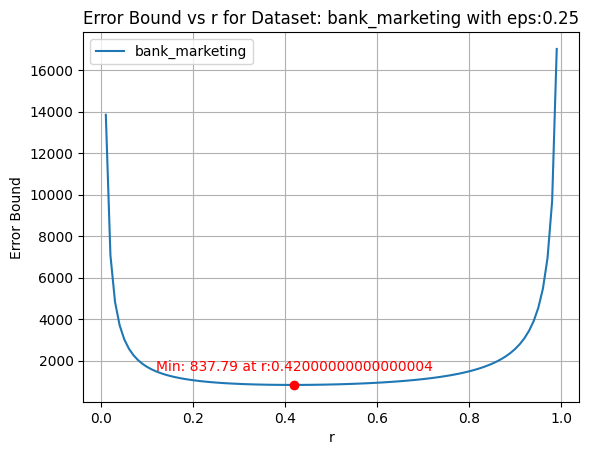

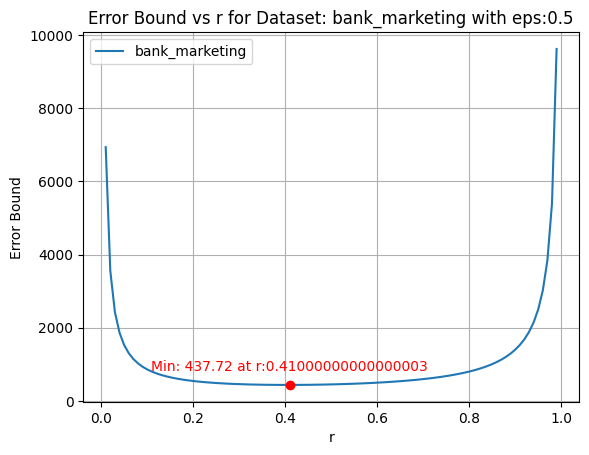

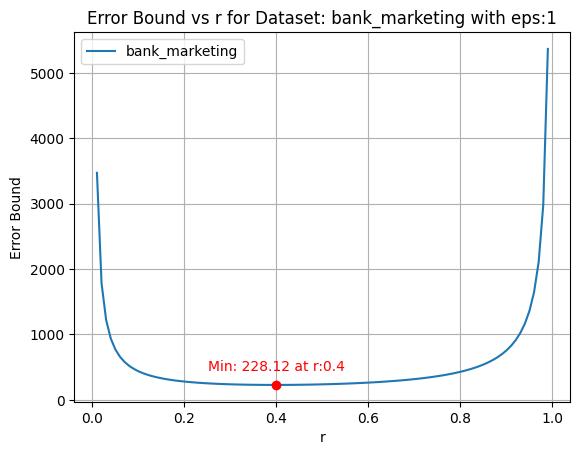

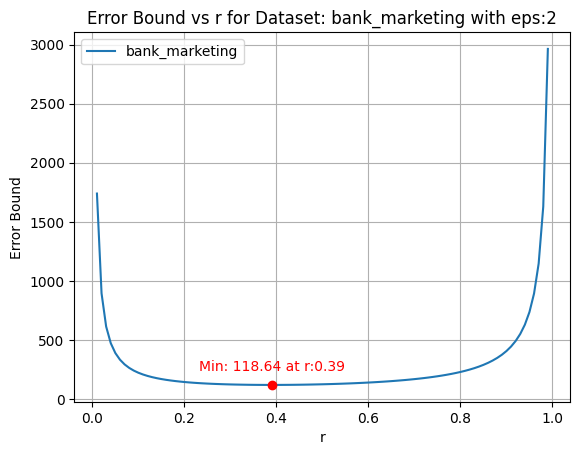

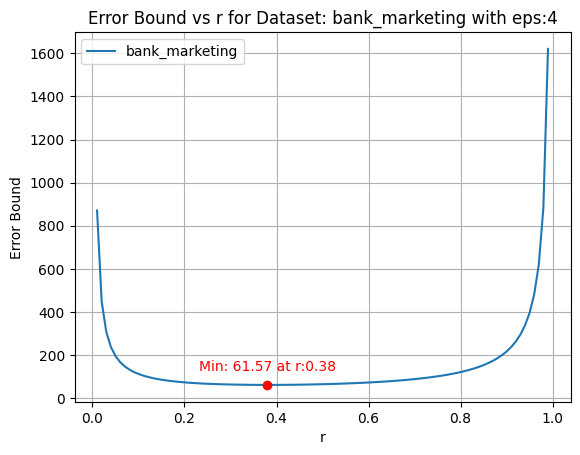

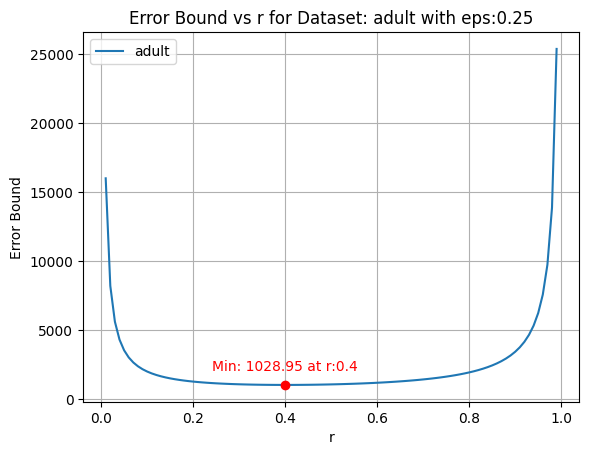

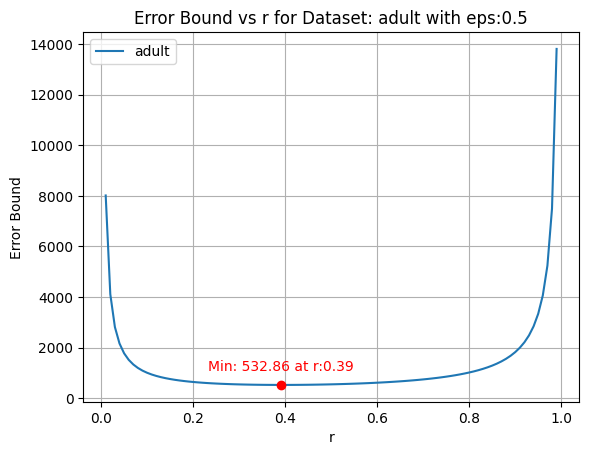

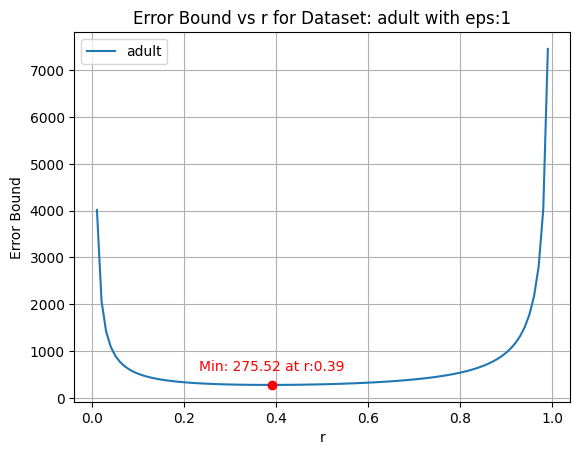

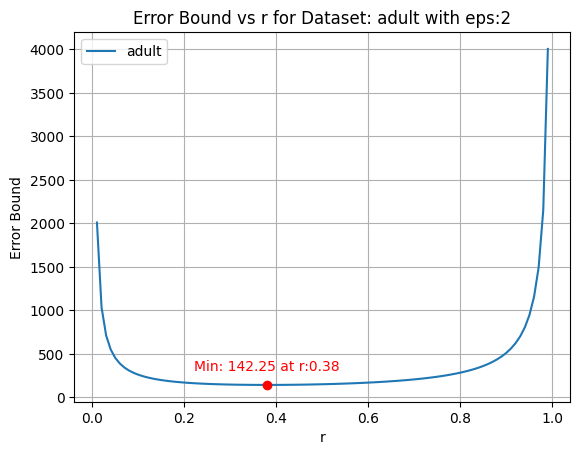

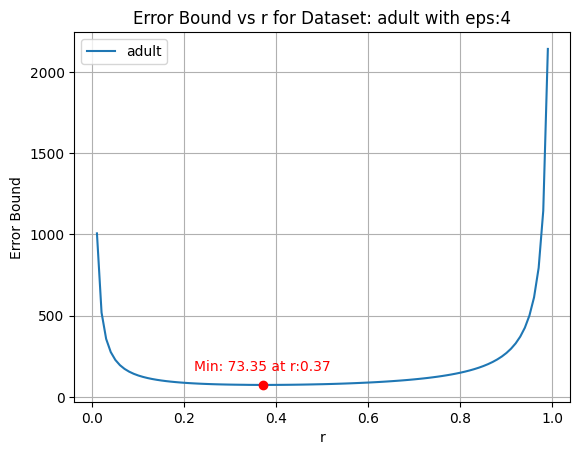

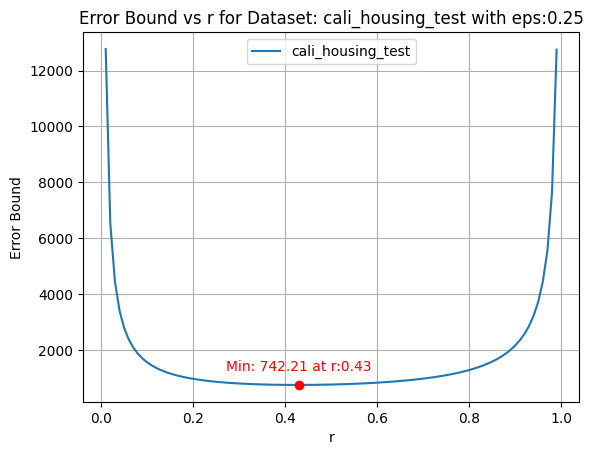

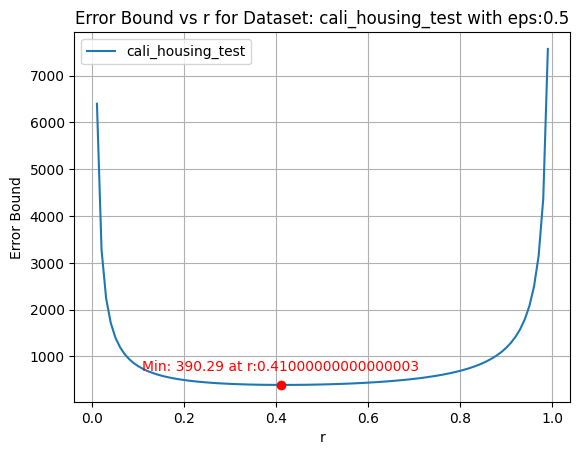

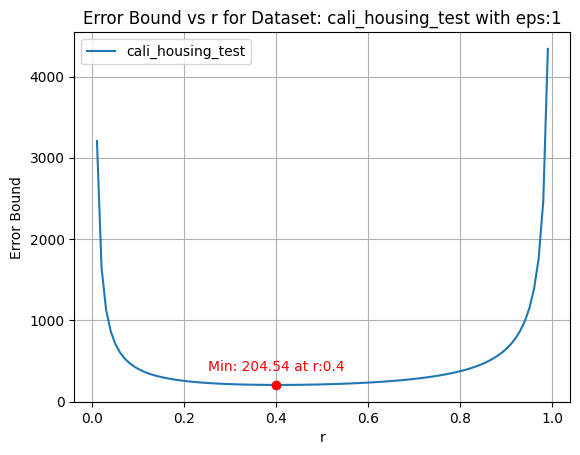

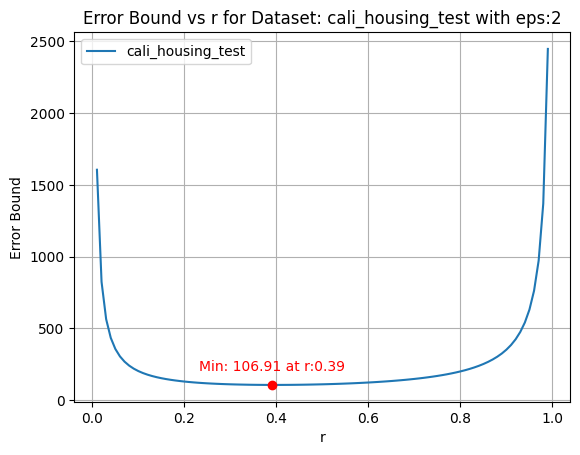

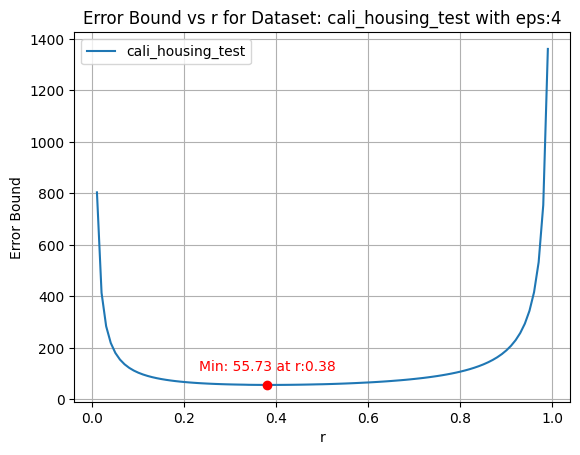

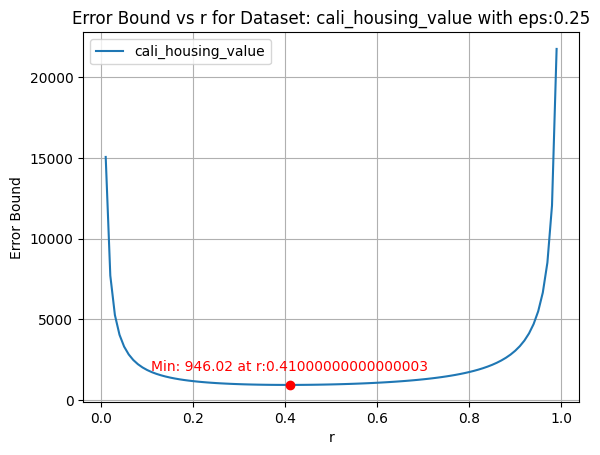

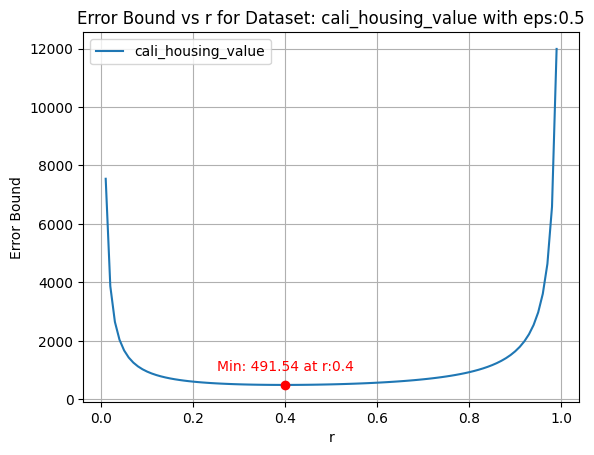

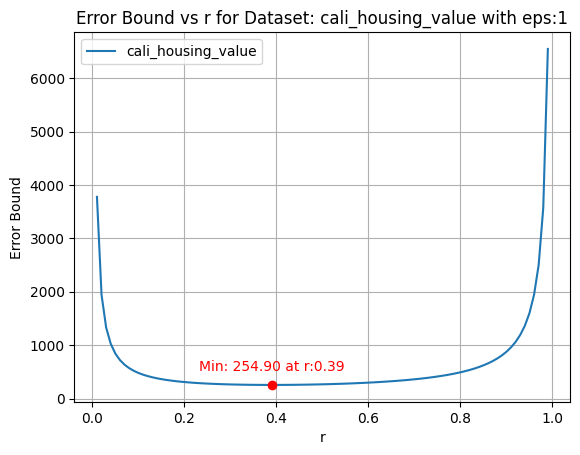

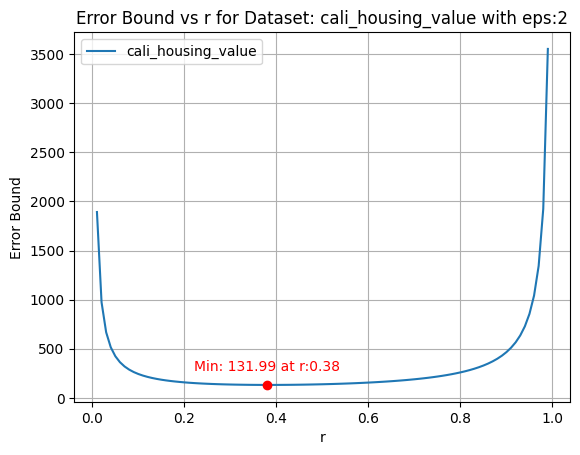

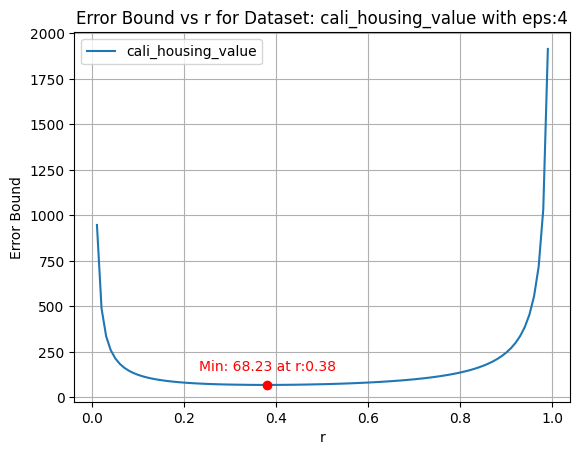

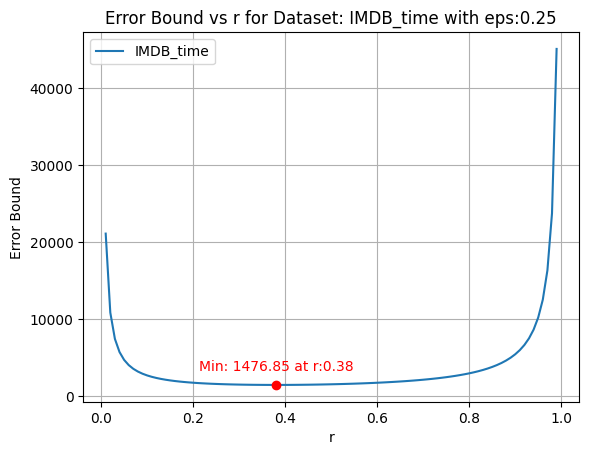

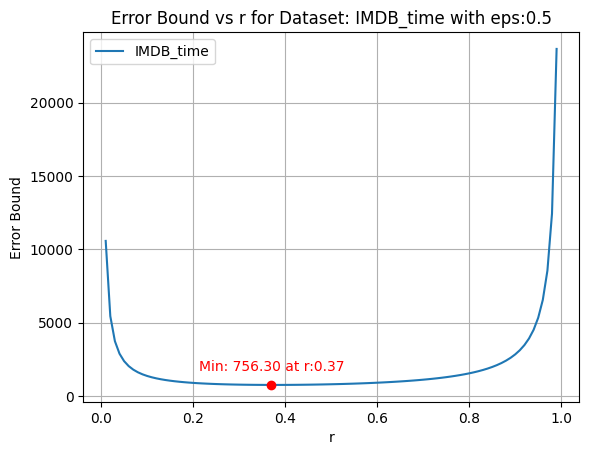

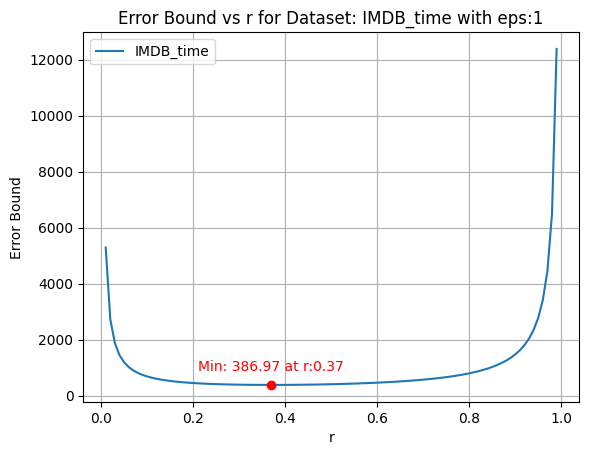

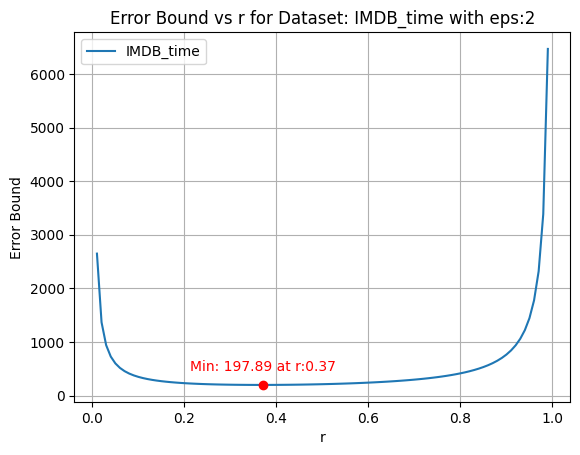

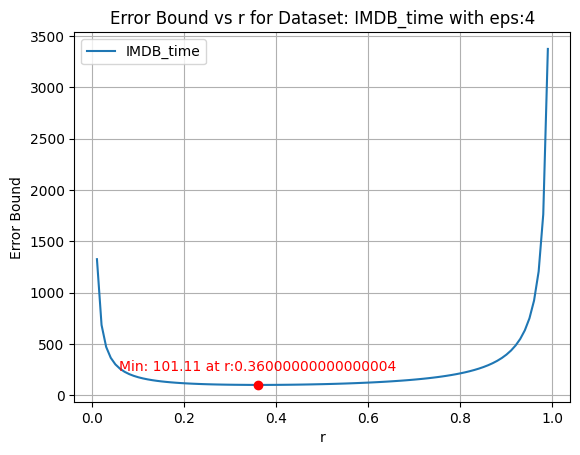

m=0, r=: 0.92
m=0, r=: 0.93
m=0, r=: 0.9400000000000001
m=0, r=: 0.9500000000000001
m=0, r=: 0.9600000000000001
m=0, r=: 0.97
m=0, r=: 0.98
m=0, r=: 0.99


<ipython-input-18-b96b330c0784>:31: RuntimeWarning: divide by zero encountered in log
  alpha = (8*np.log(m)+np.log(2/beta_2)) / eps_2


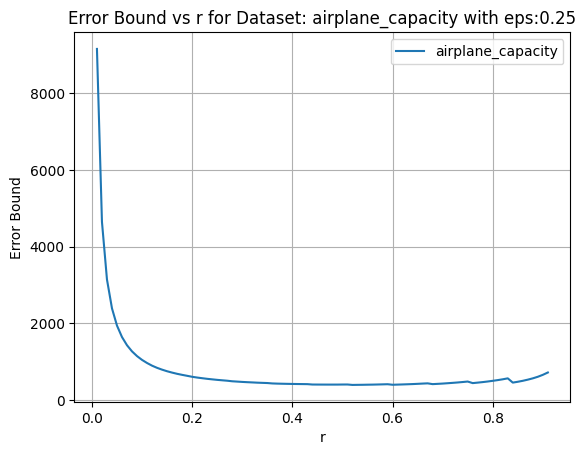

m=0, r=: 0.9600000000000001
m=0, r=: 0.97
m=0, r=: 0.98
m=0, r=: 0.99


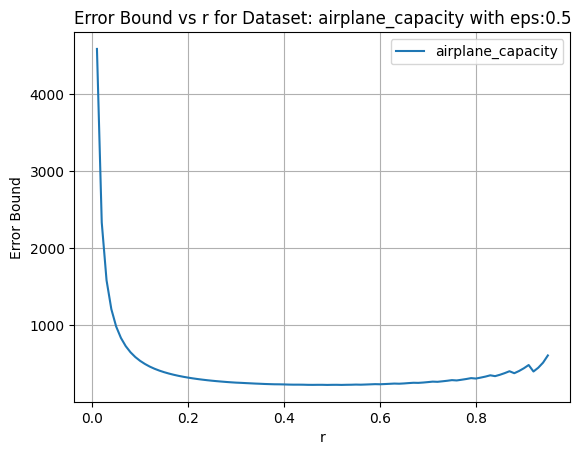

m=0, r=: 0.98
m=0, r=: 0.99


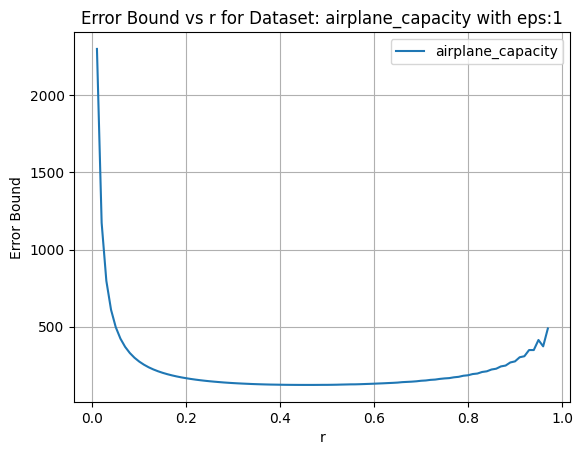

m=0, r=: 0.99


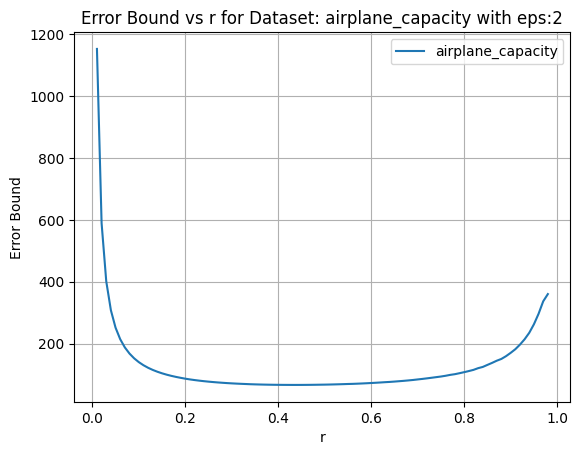

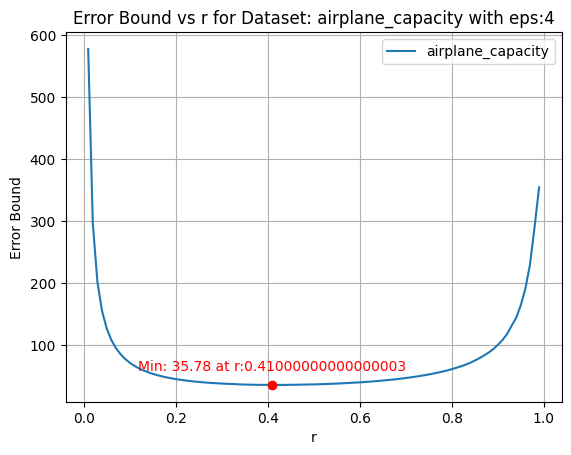

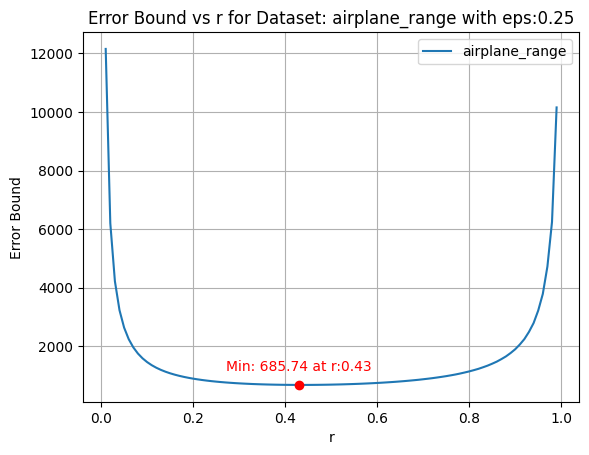

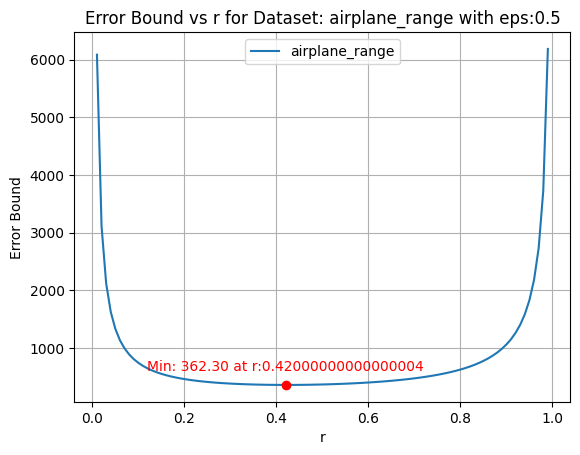

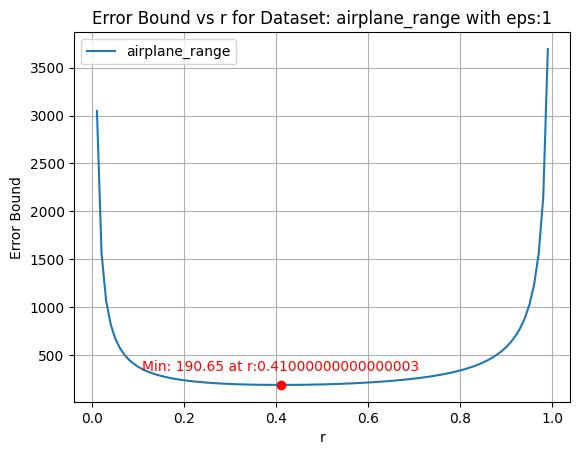

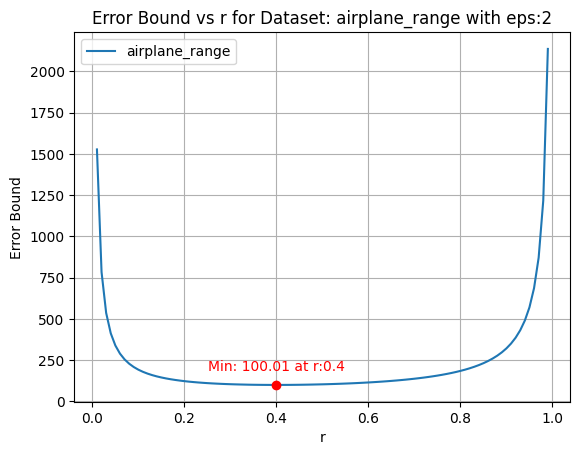

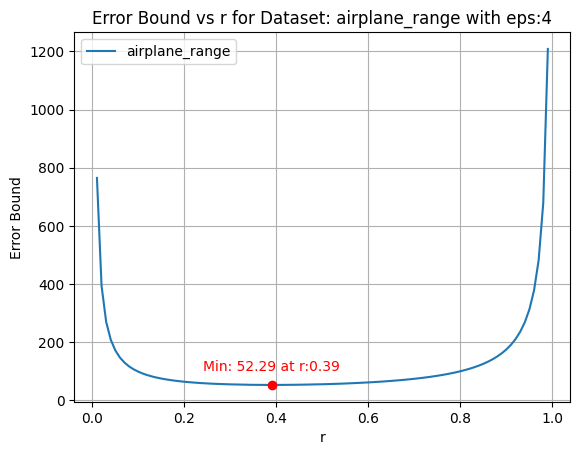

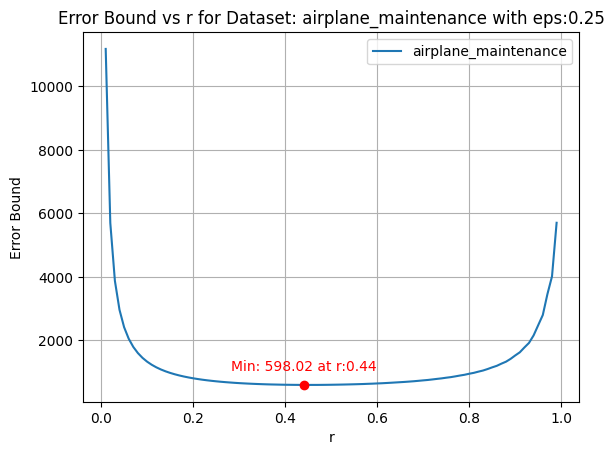

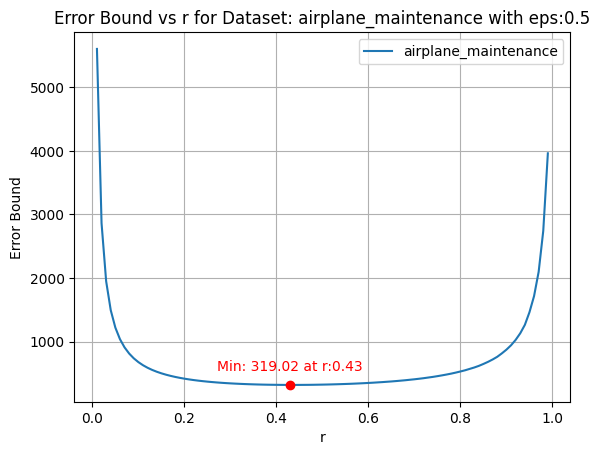

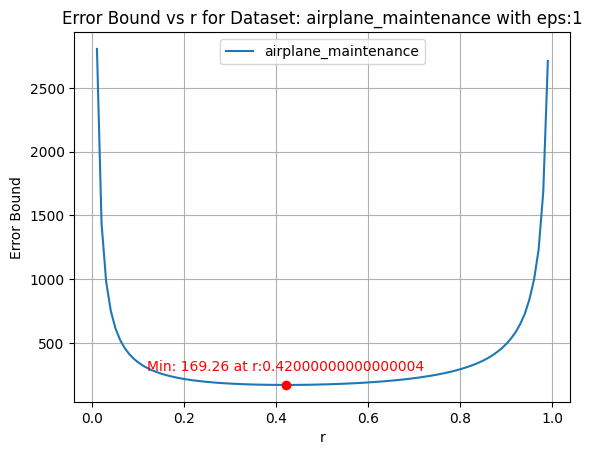

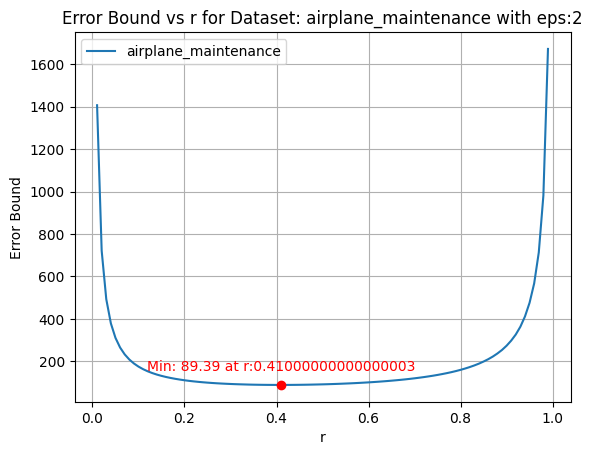

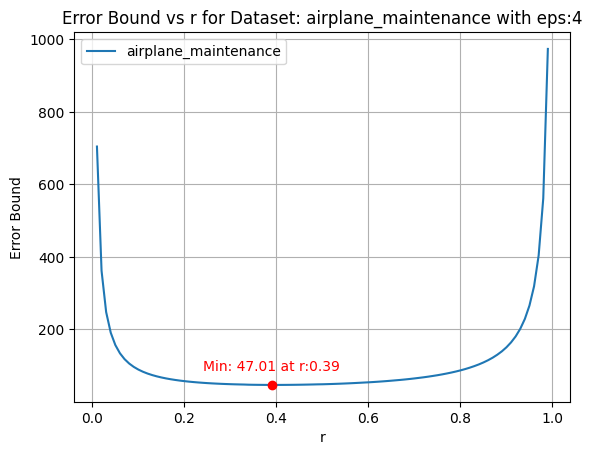

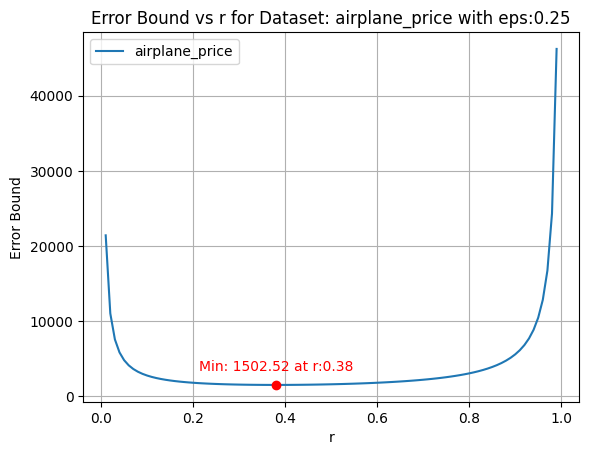

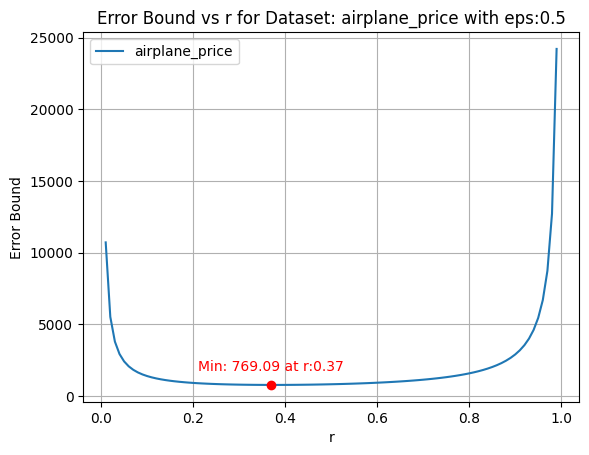

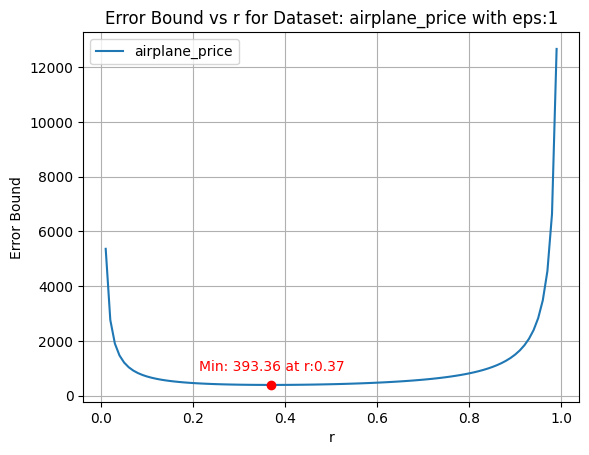

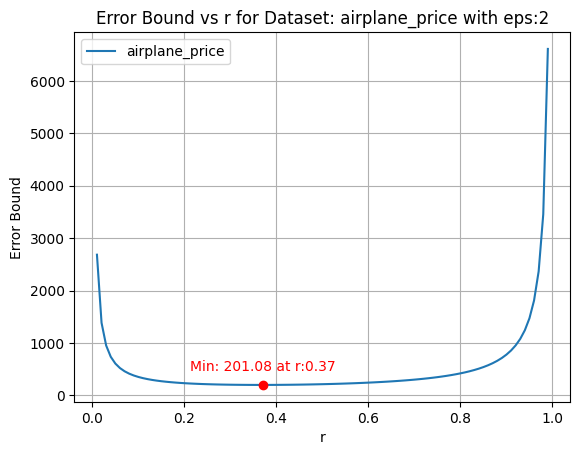

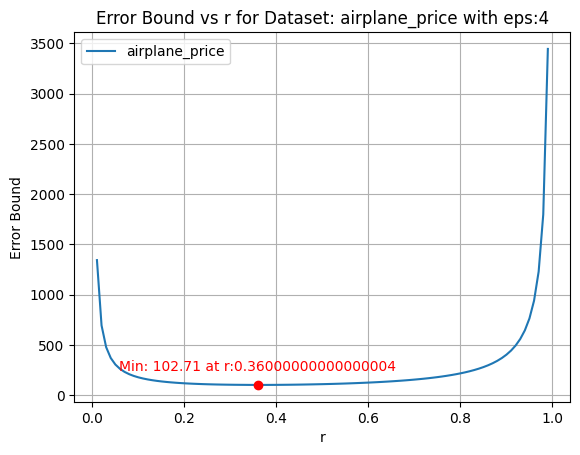

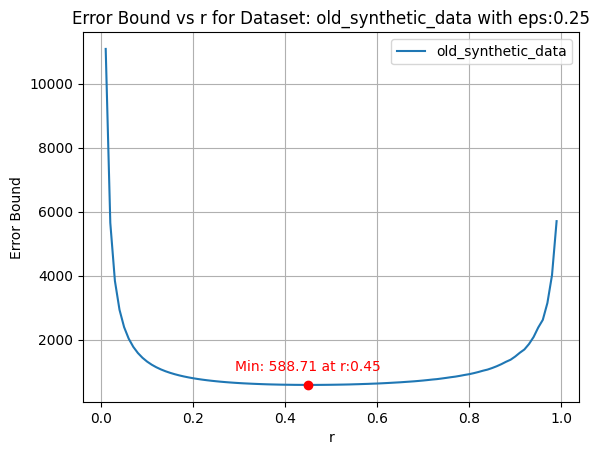

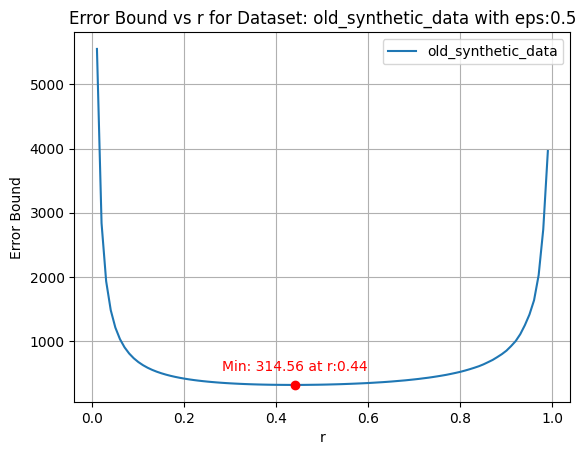

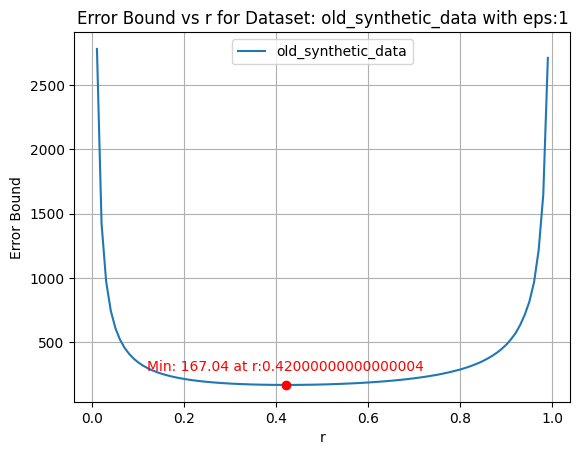

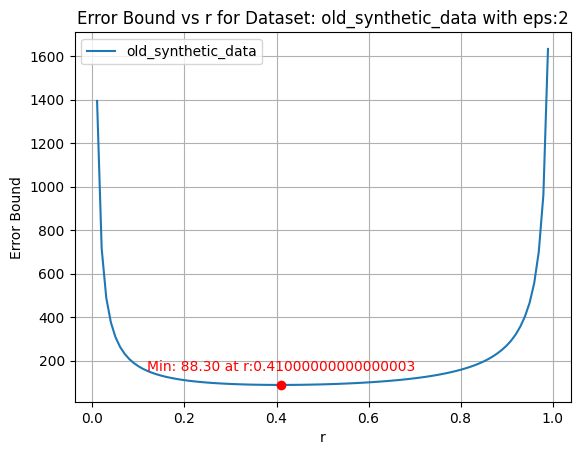

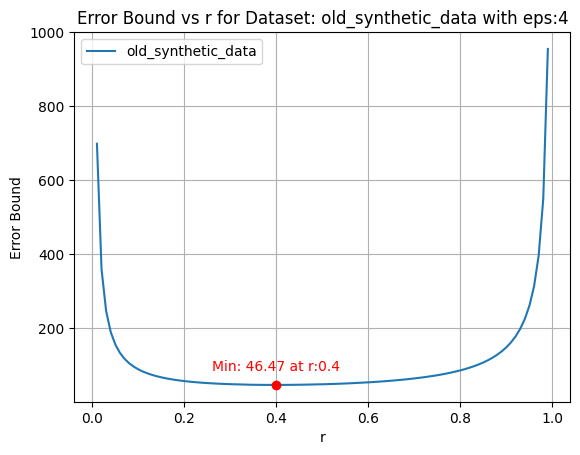

m=0, r=: 0.59
m=0, r=: 0.6
m=0, r=: 0.61
m=0, r=: 0.62
m=0, r=: 0.63
m=0, r=: 0.64
m=0, r=: 0.65
m=0, r=: 0.66
m=0, r=: 0.67
m=0, r=: 0.68
m=0, r=: 0.6900000000000001
m=0, r=: 0.7000000000000001
m=0, r=: 0.7100000000000001
m=0, r=: 0.72
m=0, r=: 0.73
m=0, r=: 0.74
m=0, r=: 0.75
m=0, r=: 0.76
m=0, r=: 0.77
m=0, r=: 0.78
m=0, r=: 0.79
m=0, r=: 0.8
m=0, r=: 0.81
m=0, r=: 0.8200000000000001
m=0, r=: 0.8300000000000001
m=0, r=: 0.8400000000000001
m=0, r=: 0.85
m=0, r=: 0.86
m=0, r=: 0.87
m=0, r=: 0.88
m=0, r=: 0.89
m=0, r=: 0.9
m=0, r=: 0.91
m=0, r=: 0.92
m=0, r=: 0.93
m=0, r=: 0.9400000000000001
m=0, r=: 0.9500000000000001
m=0, r=: 0.9600000000000001
m=0, r=: 0.97
m=0, r=: 0.98
m=0, r=: 0.99


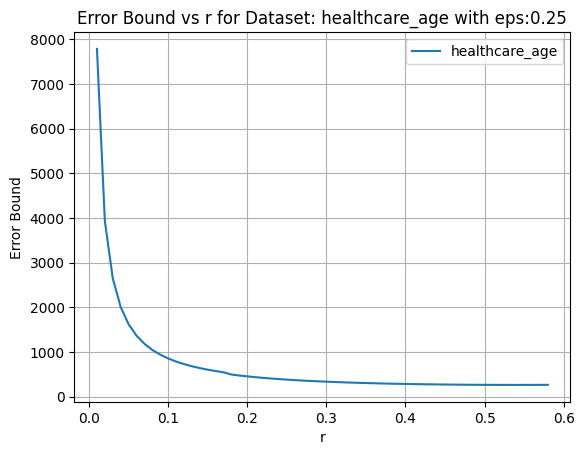

m=0, r=: 0.8
m=0, r=: 0.81
m=0, r=: 0.8200000000000001
m=0, r=: 0.8300000000000001
m=0, r=: 0.8400000000000001
m=0, r=: 0.85
m=0, r=: 0.86
m=0, r=: 0.87
m=0, r=: 0.88
m=0, r=: 0.89
m=0, r=: 0.9
m=0, r=: 0.91
m=0, r=: 0.92
m=0, r=: 0.93
m=0, r=: 0.9400000000000001
m=0, r=: 0.9500000000000001
m=0, r=: 0.9600000000000001
m=0, r=: 0.97
m=0, r=: 0.98
m=0, r=: 0.99


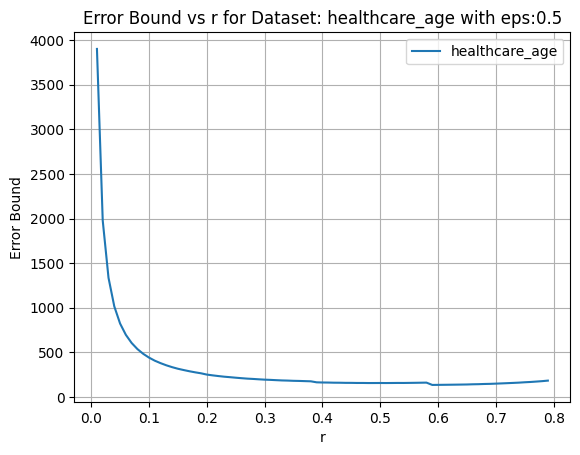

m=0, r=: 0.9
m=0, r=: 0.91
m=0, r=: 0.92
m=0, r=: 0.93
m=0, r=: 0.9400000000000001
m=0, r=: 0.9500000000000001
m=0, r=: 0.9600000000000001
m=0, r=: 0.97
m=0, r=: 0.98
m=0, r=: 0.99


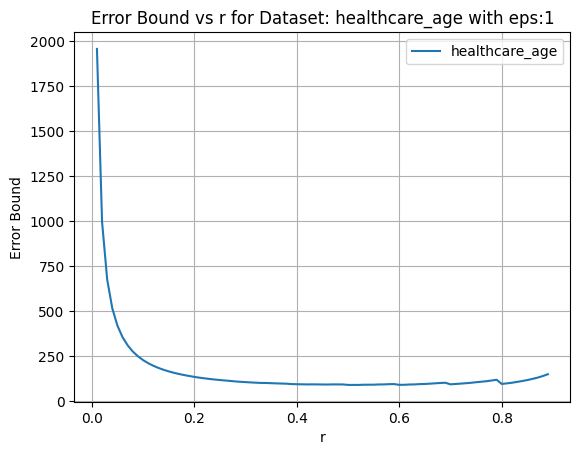

m=0, r=: 0.9500000000000001
m=0, r=: 0.9600000000000001
m=0, r=: 0.97
m=0, r=: 0.98
m=0, r=: 0.99


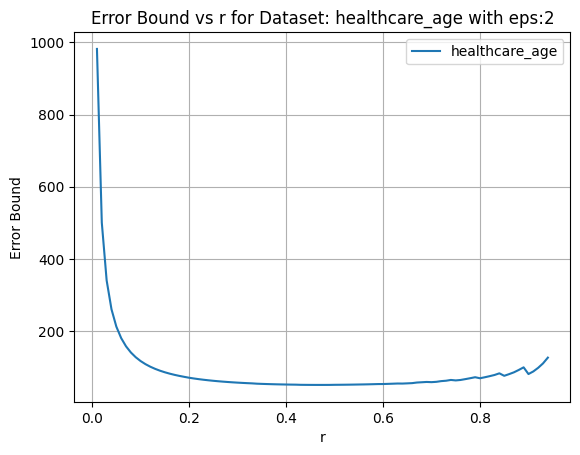

m=0, r=: 0.98
m=0, r=: 0.99


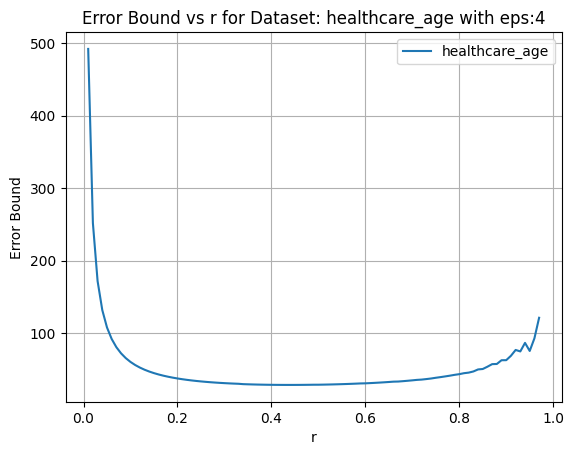

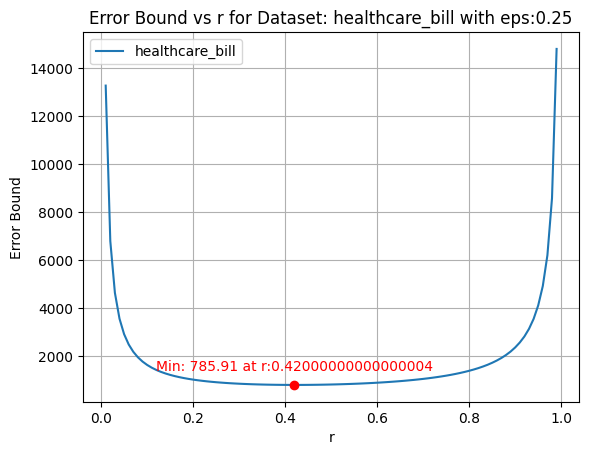

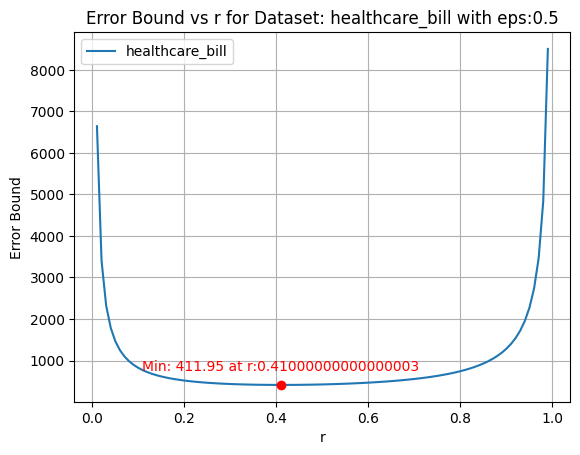

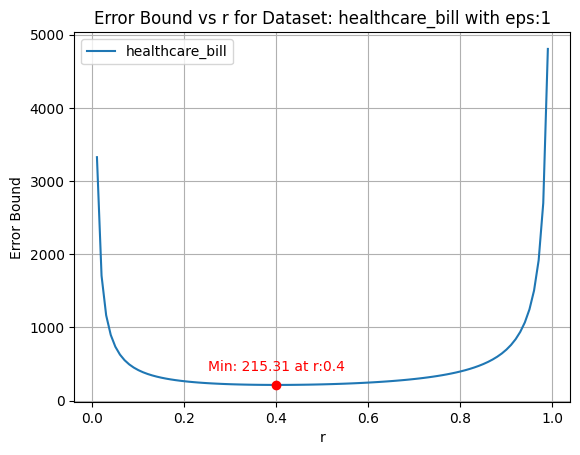

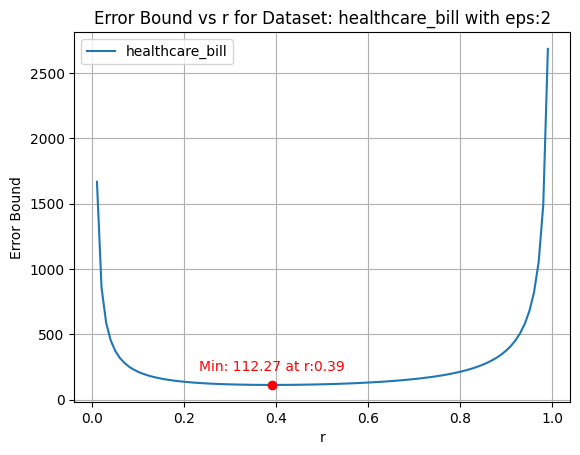

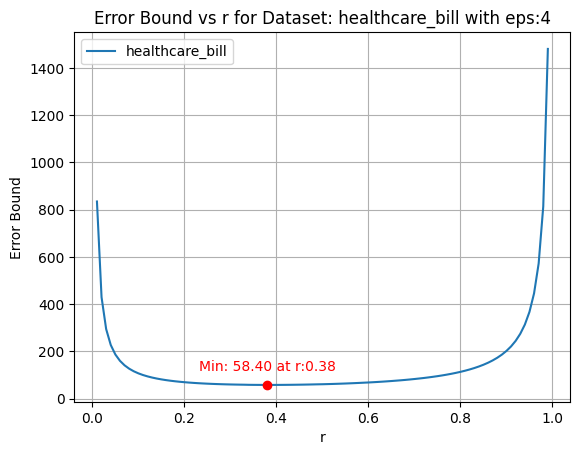

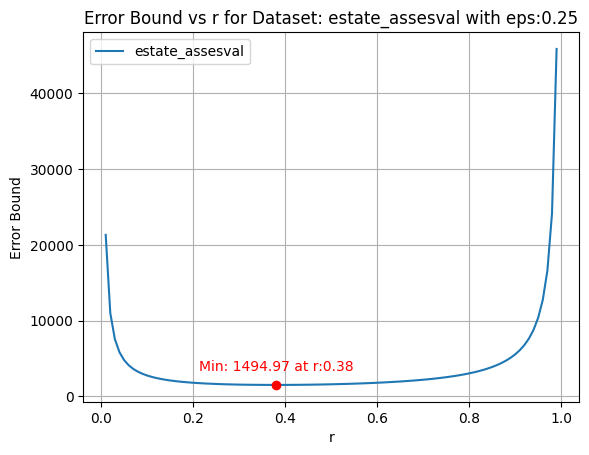

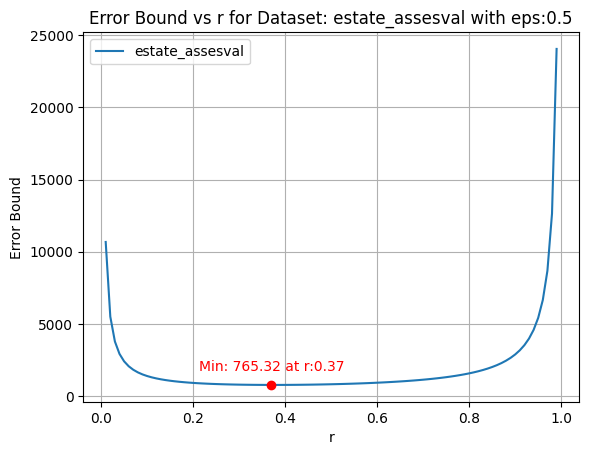

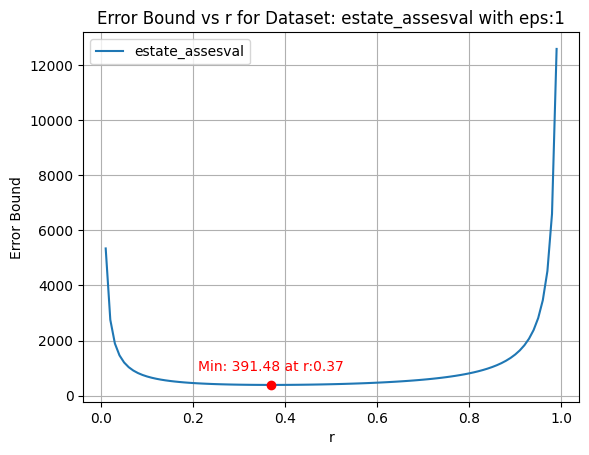

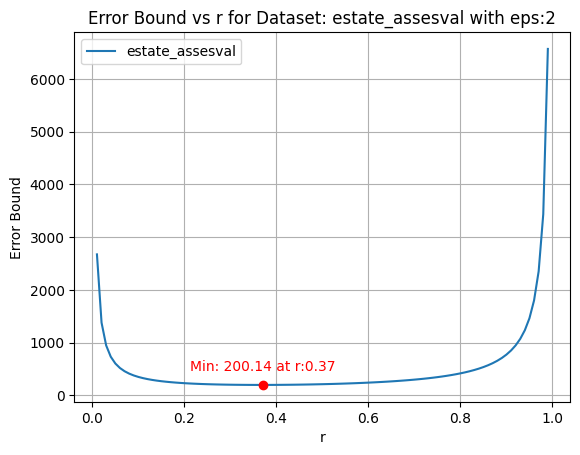

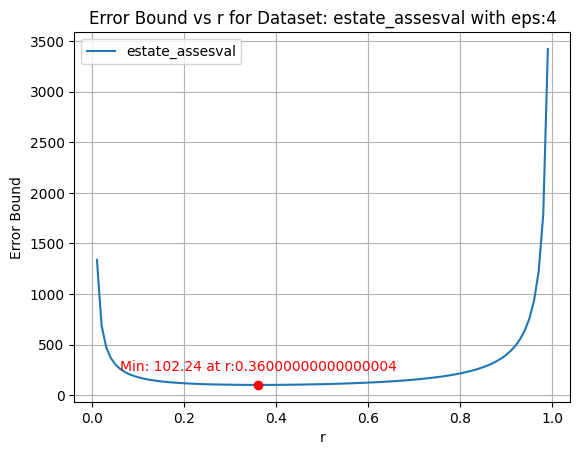

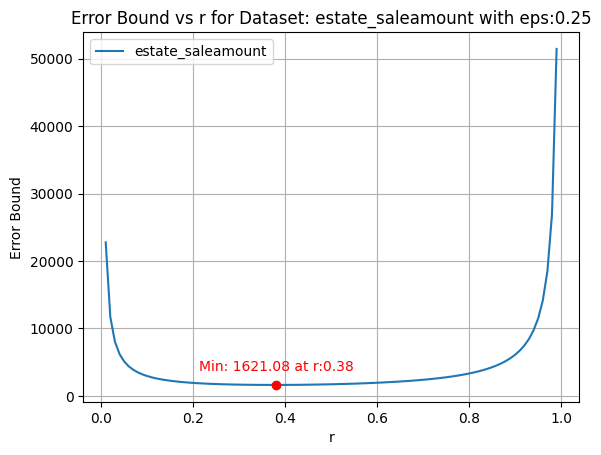

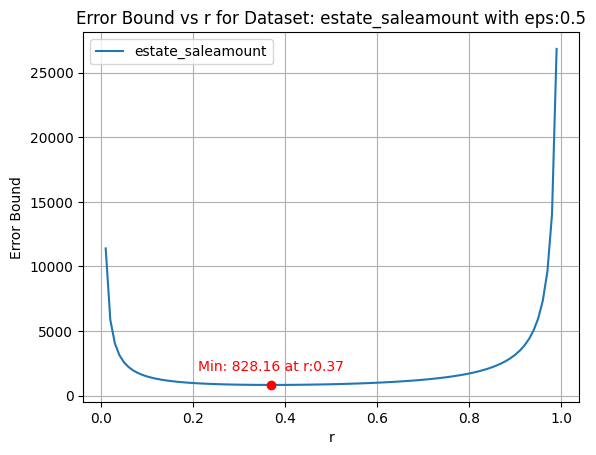

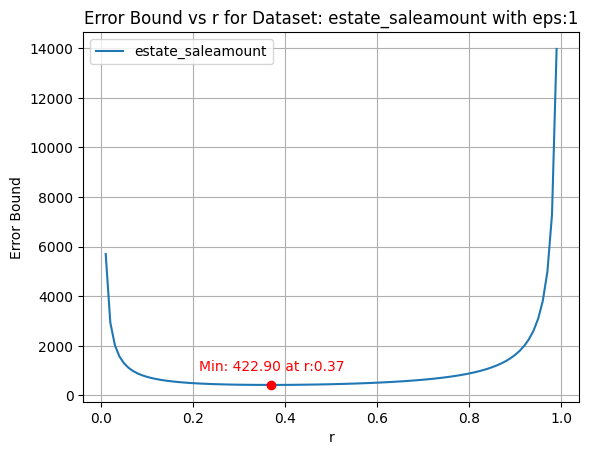

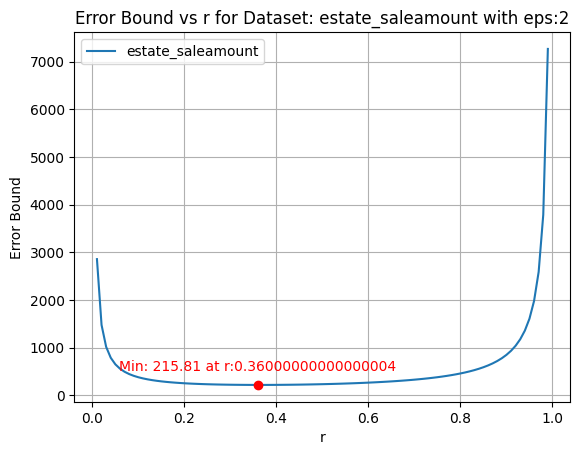

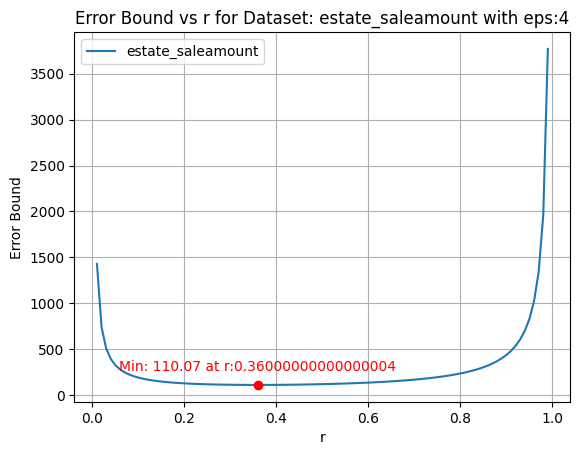

In [18]:
# Test error bound with diff eps splitting for all datasets
import matplotlib.pyplot as plt
dataset_id_dict = {0:"bank_marketing", 1:"adult", 2:"cali_housing_test", 3:"cali_housing_value",
           5:"IMDB_time",6:"airplane_capacity",7:"airplane_range",8:"airplane_maintenance",9:"airplane_price",
           10: "old_synthetic_data",11:"healthcare_age",12:"healthcare_bill",13:"estate_assesval",14:"estate_saleamount"}
eps_list = [0.25,0.5,1,2,4]
for mode,data_uuid in dataset_id_dict.items():
  # if mode == 12:
    D = readInput(mode)
    n = len(D)
    lowest = int(min(D))
    highest = int(max(D))
    domain_size = highest - lowest

    for eps_val in eps_list:
      error_bound_values = []
      eps = [eps_val]
      r_values = np.arange(0.01, 1, 0.01)
      min_error_bound = float('inf')
      min_r_value = None
      min_error = None
      for r in r_values:
        eps_1 = float(r * eps_val)
        eps_2 = float(eps_val - eps_1)
        optimized_step = int(8/eps_2)
        b_list_step = optimized_step
        # b_list_step = 1
        b_list = range(0, b_list_step*int(domain_size/b_list_step),b_list_step)
        C = (2/eps_1) *(np.log(domain_size/beta_1))
        m = len(b_list)
        alpha = (8*np.log(m)+np.log(2/beta_2)) / eps_2
        if (m == 0): print("m=0, r=:",r)
        error_bound = C + alpha + optimized_step
        error_bound_values.append(error_bound)
        if error_bound < min_error_bound:
          min_error_bound = error_bound
          min_r_value = r
          min_error = error_bound
      plt.plot(r_values, error_bound_values, label=data_uuid)
      plt.scatter(min_r_value, min_error, color='red', zorder=5)
      plt.annotate(f"Min: {min_error:.2f} at r:{min_r_value}",
              (min_r_value, min_error),
              textcoords="offset points",
              xytext=(0,10),
              ha='center', color='red')


      plt.title(f"Error Bound vs r for Dataset: {data_uuid} with eps:{eps_val}")
      plt.xlabel("r")
      plt.ylabel("Error Bound")
      plt.legend(loc="best")
      plt.grid(True)
      plt.show()

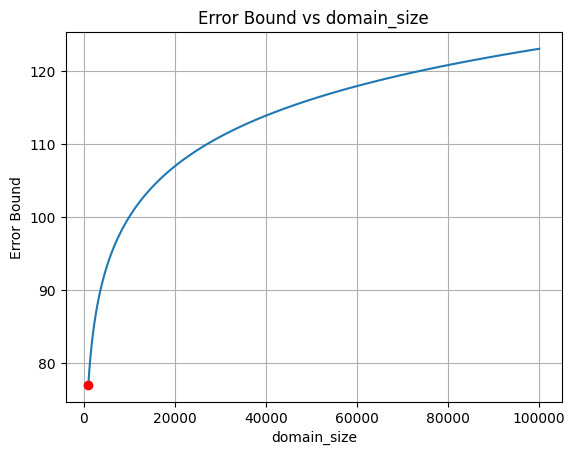

In [27]:
# Test error bound with diff domain_size
import matplotlib.pyplot as plt
dataset_id_dict = {0:"bank_marketing", 1:"adult", 2:"cali_housing_test", 3:"cali_housing_value",
           5:"IMDB_time",6:"airplane_capacity",7:"airplane_range",8:"airplane_maintenance",9:"airplane_price",
           10: "old_synthetic_data",11:"healthcare_age",12:"healthcare_bill",13:"estate_assesval",14:"estate_saleamount"}
eps_list = [0.25,0.5,1,2,4]
domain_sizes = range(1000,100000,1)
error_bound_values = []
min_error_bound = float('inf')
min_domain = None
min_error = None
r = 0.5
eps_val = 2
eps_1 = float(r * eps_val)
eps_2 = float(eps_val - eps_1)
for domain_size in domain_sizes:
  optimized_step = int(8/eps_2)
  b_list_step = optimized_step
  # b_list_step = 1
  b_list = range(0, b_list_step*int(domain_size/b_list_step),b_list_step)
  C = (2/eps_1) *(np.log(domain_size/beta_1))
  m = len(b_list)
  alpha = (8*np.log(m)+np.log(2/beta_2)) / eps_2
  if (m == 0): print("m=0, r=:",r)
  error_bound = C + alpha + optimized_step
  error_bound_values.append(error_bound)
  if error_bound < min_error_bound:
    min_error_bound = error_bound
    min_domain = domain_size
    min_error = error_bound
plt.plot(domain_sizes, error_bound_values, label=data_uuid)
plt.scatter(min_domain, min_error, color='red', zorder=5)



plt.title(f"Error Bound vs domain_size")
plt.xlabel("domain_size")
plt.ylabel("Error Bound")
plt.grid(True)
plt.show()

In [ ]:

# Test error bound with diff eps splitting for all datasets
# with diff
import matplotlib.pyplot as plt
eps_list = [0.25,0.5,1,2,4]
for mode,data_uuid in dataset_id_dict.items():
  # if mode == 1:
    D = readInput(mode)
    n = len(D)
    lowest = int(min(D))
    highest = int(max(D))
    domain_size = highest - lowest

    for eps_val in eps_list:
      error_bound_values = [[],[],[],[]]
      eps = [eps_val]
      r_values = np.arange(0, 1, 0.001)
      min_error_bound = [float('inf'),float('inf'),float('inf'),float('inf')]
      min_r_value = [None,None,None,None]
      min_error = [None,None,None,None]
      for r in r_values:
        eps_1 = r * eps_val
        eps_2 = eps_val - eps_1
        optimized_step = int(8/eps_2)
        for step_index in range(0,4):
          steps = [1,optimized_step,optimized_step*2,optimized_step/2]
          # steps = [optimized_step]*4
          b_list_step = int(steps[step_index])
          b_list = range(0, b_list_step*int(domain_size/b_list_step),b_list_step)
          C = (2/eps_1) *(np.log(domain_size/beta_1))
          m = len(b_list)
          alpha = (8*np.log(m)+np.log(2/beta_2)) / eps_2
          error_bound = C + alpha + b_list_step
          error_bound_values[step_index].append(error_bound)
          if error_bound < min_error_bound[step_index]:
            min_error_bound[step_index] = error_bound
            min_r_value[step_index] = r
            min_error[step_index] = error_bound
      for step_index in range(0,4):
        step_options = ["1","opt","opt*2","opt/2"]
        plt.plot(r_values, error_bound_values[step_index], label=data_uuid+" "+step_options[step_index])
        plt.scatter(min_r_value[step_index], min_error[step_index], color='red', zorder=5)
        plt.annotate(f"Min: {min_error[step_index]:.2f} at r:{min_r_value[step_index]}",
                (min_r_value[step_index], min_error[step_index]),
                textcoords="offset points",
                xytext=(0,10),
                ha='center', color='red')

      # plt.xlim(0.2, 0.8)  # Zoom in on the r-axis range [0.2, 0.8]
      # plt.ylim(200, 1000)
      plt.title(f"Error Bound vs r for Dataset: {data_uuid} with eps:{eps_val}")
      plt.xlabel("r")
      plt.ylabel("Error Bound")
      plt.legend(loc="best")
      plt.grid(True)
      plt.show()

In [ ]:
color_horizontally(worksheet,col_n=7,starting_col=10)

In [ ]:
import numpy as np

epsilons = np.arange(0, 1, 0.01)

C = (2/eps_1) *(np.log(domain_size/beta_1))
m = len(b_list)
alpha = (8*np.log(m)+np.log(2/beta_2)) / eps_2

for eps in epsilons:


[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99]
